In [1]:
# We will need to install following packages 
!pip install geopandas

In [2]:
!pip install mapclassify

In [3]:
#from google.colab import files
#data_to_load = files.upload()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import geopandas as gpd
from shapely.geometry import Point, Polygon
import mapclassify.classifiers as classifiers

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as sm # for regression analysis
from statsmodels.stats.outliers_influence import OLSInfluence

# may be used for visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

# Data Sets

The first section of this notebook will import each of the datasets that is used, and clean them as necssary.

## Presidential Vote Count Data Set

In [5]:
# load vote count data for the presidential election
votes_pres_list = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/president_county_candidate_2020_kaggle.csv?raw=true')
votes_pres_list['county'] = votes_pres_list['county'].str.replace('Do�a','Doña')
votes_pres_list.head(3)

state       county     candidate party  total_votes    won
0  Delaware  Kent County     Joe Biden   DEM        44552   True
1  Delaware  Kent County  Donald Trump   REP        41009  False
2  Delaware  Kent County  Jo Jorgensen   LIB         1044  False

Note that each row has a separate candidate. We would like to convert this so that each row has a single county.

In [6]:
votes_pres_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        32177 non-null  object
 1   county       32177 non-null  object
 2   candidate    32177 non-null  object
 3   party        32177 non-null  object
 4   total_votes  32177 non-null  int64 
 5   won          32177 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.3+ MB


In [7]:
# we are interested in the votes for Biden, Trump, and potentially 'other'

# calculate the number of 'other' votes for each county (those for someone other than Biden or Trump)
votes_pres_other = votes_pres_list.pivot(index=['state', 'county'], columns="candidate", values='total_votes')
votes_pres_other.drop(['Joe Biden', 'Donald Trump'], axis=1, inplace=True)
votes_pres_other['Other'] = votes_pres_other[list(votes_pres_other.columns)].sum(axis=1)

# remove rows for candidates other than Joe Biden and Donald Trump
votes_pres_list2 = votes_pres_list.loc[votes_pres_list.candidate.isin(['Joe Biden', 'Donald Trump'])]

# convert the data so that there is one row per county in the USA
votes_pres = votes_pres_list2.pivot(index=['state', 'county'], columns="candidate", values=['total_votes', 'won'])

# add the number of votes for other candidates in each county
votes_pres['total_votes','Other'] = votes_pres_other['Other'].astype('int')

# clean up index, columns, and data types
votes_pres.sort_index(axis=1, inplace=True)
votes_pres.reset_index(inplace=True)
votes_pres.columns = ['state', 'county', 'votes_tru', 'votes_bid', 'votes_oth', 'won_tru', 'won_bid']
votes_pres = votes_pres.convert_dtypes()
votes_pres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4633 entries, 0 to 4632
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      4633 non-null   string 
 1   county     4633 non-null   string 
 2   votes_tru  4633 non-null   Int64  
 3   votes_bid  4633 non-null   Int64  
 4   votes_oth  4633 non-null   Int64  
 5   won_tru    4633 non-null   boolean
 6   won_bid    4633 non-null   boolean
dtypes: Int64(3), boolean(2), string(2)
memory usage: 212.8 KB


The election (votes) data has 4633 rows, but there are only 3142 counties in the United States.

We will want to merge the voting data with the county characteristics (cc) data, which has 3142 rows (each row represents a county).

The following states have multiple municipalities (towns) listed in the voter data that should match to a single county in the county characteristics data. The following websites were used to get lists indicating what municipalityies (towns) were in which county.
- Connecticut: https://ctstatelibrary.org/cttowns/counties
- Maine: https://www.citypopulation.de/en/usa/maine/admin/
- Massachusetts: https://www.sec.state.ma.us/ele/elecct/cctidx.htm
- New Hampshire: https://www.nh.gov/osi/resource-library/municipalities.htm
- Rhode Island: https://en.wikipedia.org/wiki/List_of_municipalities_in_Rhode_Island
- Vermont (see turnout doc): https://sos.vermont.gov/elections/election-info-resources/elections-results-data/

The data from each of these websites was used to populate a 'counties_towns.xlsx' spreadsheet, where each tab of the spreadsheet lists a different state's municipalities (towns) and corresponding county.

For Alaska, the voting electoral districts did not match up with the census data, but no mapping could be found.  The Alaska data will therefore be excluded from the analysis.

For the District of Columbia, the equivalent demographic data is not available from the US Census so DC will also be excluded from the analysis.

In [8]:
# load the counties_towns data for the states listed above
town_counties = {}
state_dict = {'CT': 'Connecticut', 'MA': 'Massachusetts', 'ME': 'Maine', 'NH': 'New Hampshire', 'RI': 'Rhode Island', 'VT': 'Vermont'}
for s in state_dict.keys():
    town_counties[s] = pd.read_excel('https://github.com/oke-w/election_2020/blob/main/counties_towns.xlsx?raw=true', sheet_name = s)
    town_counties[s].sort_values(by='town', inplace=True)
    town_counties[s].set_index('town', inplace=True)
st = 'MA'
# print(town_counties[st].shape) # for troubleshooting
town_counties[st].head(3)

county
town                      
Abington   Plymouth County
Acton     Middlesex County
Acushnet    Bristol County

In [9]:
#votes_pres[votes_pres.state == state_dict[st]].shape[0] # for troubleshooting

In [10]:
# add a county column to the voting data and rename the existing column to 'town'
votes_pres_towns = {}
for s in state_dict.keys():
    votes_pres_towns[s] = votes_pres[votes_pres.state == state_dict[s]].copy()
    print(votes_pres_towns[s].shape[0]) # number of rows (towns) in the state
    votes_pres_towns[s].rename(columns={'county':'town'},inplace=True)
    votes_pres_towns[s] = votes_pres_towns[s].join(town_counties[s], on='town')

votes_pres_towns[st].head(3)

169
351
498
237
39
246


state      town  votes_tru  votes_bid  votes_oth  won_tru  \
1878  Massachusetts  Abington       4236       5209        215    False   
1879  Massachusetts     Acton       2471      11105        351    False   
1880  Massachusetts  Acushnet       3290       2664        114     True   

      won_bid            county  
1878     True   Plymouth County  
1879     True  Middlesex County  
1880    False    Bristol County

In [11]:
#verification / troubleshooting of the join:
#out = votes_pres_towns[st].join(town_counties[st], on='town', how='left', lsuffix='_votes')
#display(out[out.county_votes.isnull()])
#out[out.county.isnull()]
#votes_pres.merge(cc19_age, on=['state','county'], how='outer', indicator=True)
#votes_pres_towns[st].loc[votes_pres_towns[st]['town'].duplicated()]
#votes_pres_towns[st][votes_pres_towns[st].duplicated()]

In [12]:
# combine the municipalities so that there is one row per county in the USA
votes_pres_fixes = {}
for s in state_dict.keys():
    votes_pres_fixes[s] = votes_pres_towns[s].groupby('county').sum()
    votes_pres_fixes[s].reset_index(inplace=True) # convert 'county' intex to column
    votes_pres_fixes[s]['won_tru'] = [np.nan] * len(votes_pres_fixes[s])
    votes_pres_fixes[s]['won_bid'] = [np.nan] * len(votes_pres_fixes[s])
    votes_pres_fixes[s]['state'] = [state_dict[s]] * len(votes_pres_fixes[s])
# note: we cannot combine the town 'won' values to determine who won in each riding
# we will have to calculate it based on the number of votes
votes_pres_fixes[st]

county  votes_tru  votes_bid  votes_oth  won_tru  won_bid  \
0   Barnstable County      55311      91994       3020      NaN      NaN   
1    Berkshire County      18064      51705       1606      NaN      NaN   
2      Bristol County     119872     153377       6030      NaN      NaN   
3        Dukes County       2631       9914        253      NaN      NaN   
4        Essex County     144837     267198       9175      NaN      NaN   
5     Franklin County      11201      30030       1227      NaN      NaN   
6      Hampden County      87318     125948       4911      NaN      NaN   
7    Hampshire County      22281      63362       2211      NaN      NaN   
8    Middlesex County     226956     617196      19425      NaN      NaN   
9    Nantucket County       1914       5241        151      NaN      NaN   
10     Norfolk County     125294     273312       9145      NaN      NaN   
11    Plymouth County     121227     173630       6959      NaN      NaN   
12     Suffolk County      58613     270522       6327      NaN      NaN   
13   Worcester County     171683     248773      11558      NaN      NaN   

            state  
0   Massachusetts  
1   Massachusetts  
2   Massachusetts  
3   Massachusetts  
4   Massachusetts  
5   Massachusetts  
6   Massachusetts  
7   Massachusetts  
8   Massachusetts  
9   Massachusetts  
10  Massachusetts  
11  Massachusetts  
12  Massachusetts  
13  Massachusetts

In [13]:
# remove (drop) the towns from the voting data and add the 'fixed data' for each county
for s in state_dict.keys():
    idx = votes_pres.loc[votes_pres.state == state_dict[s]].index
    votes_pres.drop(idx, inplace=True)
    votes_pres = votes_pres.append(votes_pres_fixes[s], ignore_index=True)

In [14]:
# drop the data for Alaska since the voting data can't be merged with the county stcharacteristics data
idx = votes_pres.loc[votes_pres.state == 'Alaska'].index
votes_pres.drop(idx, inplace=True)

In [15]:
# drop the data for DC since the same county characteristics aren't available
idx = votes_pres.loc[votes_pres.state == 'District of Columbia'].index
votes_pres.drop(idx, inplace=True)

In [16]:
# Illinois voting data contained "Cook County" and "Cook Suburbs" data, which needs to be merged
# into "Cook County" data to match the county characteristics data
row1 = votes_pres.loc[(votes_pres.state == "Illinois") & (votes_pres.county == 'Cook County')].index
row2 = votes_pres.loc[(votes_pres.state == "Illinois") & (votes_pres.county == 'Cook Suburbs')].index
cols = ['votes_tru', 'votes_bid', 'votes_oth']

for col in cols:
    votes_pres.at[row1[0], col] += votes_pres.at[row2[0], col]
votes_pres.drop(row2[0], inplace=True)

In [17]:
# create new columns in the voting data for total votes in each county, and percentage of votes for Trump & Biden
votes_pres['votes_tot'] = votes_pres[['votes_tru', 'votes_bid', 'votes_oth']].sum(axis=1)
votes_pres['pct_tru'] = votes_pres['votes_tru'] / votes_pres['votes_tot']
votes_pres['pct_bid'] = votes_pres['votes_bid'] / votes_pres['votes_tot']
votes_pres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3159
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      3111 non-null   object 
 1   county     3111 non-null   object 
 2   votes_tru  3111 non-null   Int64  
 3   votes_bid  3111 non-null   Int64  
 4   votes_oth  3111 non-null   Int64  
 5   won_tru    3044 non-null   boolean
 6   won_bid    3044 non-null   boolean
 7   votes_tot  3111 non-null   float64
 8   pct_tru    3111 non-null   float64
 9   pct_bid    3111 non-null   float64
dtypes: Int64(3), boolean(2), float64(3), object(2)
memory usage: 240.0+ KB


## County Characteristics Data Set

The county characteristics dataset (174MB) was downloaded from the US Census Bureau and contains Age, Sex, and Ethnic/Language demographic data for every county in the US.

The dataset had 12 years worth of population data, so the most recent (2019) data was extracted and saved to `cc-2019.csv` as follows:<br>
`counties = pd.read_csv('cc-est2019-alldata.csv')`<br>
`cc19 = counties[counties.YEAR == 12]`<br>
`counties_2019.to_csv('cc-2019.csv')`

`cc-2019.csv` was then posted to the GitHub link below.

In [18]:
cc19 = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/cc-2019.csv?raw=true', dtype='str')
# convert population data to int format
for n in range(8, len(cc19.columns)):
    cc19.iloc[:,n] = cc19.iloc[:,n].astype('int')

cc19['CTYNAME'] = cc19['CTYNAME'].str.replace('Do�a','Doña') # fix the improper character
cc19.head(3)

Unnamed: 0 SUMLEV STATE COUNTY   STNAME         CTYNAME YEAR AGEGRP  \
0        209     50     1      1  Alabama  Autauga County   12      0   
1        210     50     1      1  Alabama  Autauga County   12      1   
2        211     50     1      1  Alabama  Autauga County   12      2   

   TOT_POP  TOT_MALE  ...  HWAC_MALE  HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  \
0    55869     27092  ...        778          687         89           93   
1     3277      1713  ...         76           53         10            6   
2     3465      1787  ...         83           59          2           10   

   HIAC_MALE  HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  HNAC_FEMALE  
0         40           27         15           19         16           11  
1          6            5          3            4          3            3  
2          8            2          2            0          1            1  

[3 rows x 81 columns]

The original dataset has numerous combinations of age, sex, ethnic, and language data.  A description of the columns is available [here](https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf).

The following ethnic catagories are probably most relevant:

| Code | Meaning |
|  :-  |   :-   |
| 'WA_MALE', 'WA_FEMALE'  |  WA: white alone |
| 'BAC_MALE', 'BAC_FEMALE' | BA: black american |
| 'IAC_MALE', 'IAC_FEMALE' | IA: native (indian american) |
| 'AAC_MALE', 'AAC_FEMALE' | AA: asian american |
| 'H_MALE', 'H_FEMALE': | H: hispanic |

Select the ethnic and language columns of interest regardless of age:

In [19]:
# WA: white alone, BA: black american, IA: native (indian american), AA: asian, H: hispanic
cols = ['STNAME', 'CTYNAME', 'AGEGRP', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE',
        'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']
# select rows and columns of relevance for race dataframe.  AGEGRP == 0 corresponds to all age groups
cc19_race = cc19[cc19.AGEGRP == '0'][cols]
cc19_race.reset_index(drop=True, inplace=True)
cc19_race.drop(columns='AGEGRP', inplace=True)
cc19_race.rename(columns={'STNAME':'state', 'CTYNAME':'county'}, inplace=True)

cc19_race.head(3)

state          county  TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  \
0  Alabama  Autauga County    55869     27092       28777    20878      21729   
1  Alabama  Baldwin County   223234    108247      114987    94810     100388   
2  Alabama  Barbour County    24686     13064       11622     6389       5745   

   BAC_MALE  BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  AAC_FEMALE  H_MALE  \
0      5514        6270       274         301       441         509     884   
1     10346       11008      1818        1785      1405        1946    5545   
2      6432        5685       182         115        72          80     629   

   H_FEMALE  
0       787  
1      4989  
2       488

A description of the age groups is available here. In short, there are 18 age groups, where:
* AGEGRP 1 is ages 0-4;
* AGEGRP 2 is ages 5-9;
* etc; and
* AGEGRP 18 is age 85+.

Below we group the age groups into:
* CHILD: 0-18 (non-voters)
* YG_ADLT: 19-40
* MID_AGE: 40-60
* SENIOR: 60+

Note: the 4th AGEGRP was split 60% into CHILD and 40% into YG_ADLT.

In [20]:
# consider the following age groups: child (0-17), young adult (18-39), middle age (40-60), senior (60+)
cols = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'AGEGRP', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE']
# convert 'AGEGRP' from single column to a column for each age group
cc19_age_pivot = cc19[cols].pivot(index=['STNAME', 'CTYNAME'], columns="AGEGRP", values=['TOT_POP', 'TOT_MALE', 'TOT_FEMALE'])
cc19_age_pivot.head(3)

TOT_POP                                            \
AGEGRP                       0      1     10     11     12     13     14   
STNAME  CTYNAME                                                            
Alabama Autauga County   55869   3277   3877   3775   3896   3370   2683   
        Baldwin County  223234  12039  14472  14319  16267  16148  14881   
        Barbour County   24686   1309   1578   1504   1709   1540   1501   

                                           ... TOT_FEMALE                    \
AGEGRP                     15    16    17  ...         17    18     2     3   
STNAME  CTYNAME                            ...                                
Alabama Autauga County   2330  1796  1179  ...        681   577  1678  1874   
        Baldwin County  13163  9043  5297  ...       2827  2609  6338  6972   
        Barbour County   1365   939   587  ...        353   317   724   736   

                                                            
AGEGRP                     4     5     6     7     8     9  
STNAME  CTYNAME                                             
Alabama Autauga County  1805  1544  1941  1803  1899  1925  
        Baldwin County  6505  5490  6377  6420  6895  6863  
        Barbour County   663   598   644   659   634   549  

[3 rows x 57 columns]

In [21]:
# combine the data AGEGRPs (codes #1-18) into named aged groups (CHILD through SENIOR)
def create_age_group(data, stat, gp_name, age_grp_nos, rates):
    data[stat, gp_name] = np.zeros(len(data.index)).astype(int)
    for n, grp in enumerate(age_grp_nos):
        data[stat, gp_name] += (data[stat, grp] * rates[n]).astype(int)

In [22]:
# consider the following age groups: child (0-17), young adult (18-39), middle age (40-60), senior (60+)
# AGEGRPs: child (1+2+3+4*(3/5)), young adult (4*(2/5)+5+6+7+8), middle age (9-12), senior (13-18)
stat_list = ['TOT_POP', 'TOT_MALE', 'TOT_FEMALE']
for stat in stat_list:
    create_age_group(cc19_age_pivot, stat, 'CHILD', ['1', '2', '3', '4'], [1, 1, 1, 0.6])
    create_age_group(cc19_age_pivot, stat, 'YG_ADLT', ['4', '5', '6', '7', '8'], [0.4, 1, 1, 1, 1])
    create_age_group(cc19_age_pivot, stat, 'MID_AGE', ['9', '10', '11', '12'], [1, 1, 1, 1])
    create_age_group(cc19_age_pivot, stat, 'SENIOR', ['13', '14', '15', '16', '17', '18'], [1, 1, 1, 1, 1, 1])

# only keep the newly created age group columns (the last 12 columns)
cc19_age = cc19_age_pivot.iloc[:,-12:]

# clean up the column names
cc19_age.reset_index(inplace=True)
cc19_age.rename(columns={'STNAME':'state', 'CTYNAME':'county'}, inplace=True)
cc19_age.columns = ['state', 'county', 'child', 'yg_adlt', 'mid_age', 'senior',\
                       'child_m', 'yg_adlt_m', 'mid_age_m', 'senior_m', 'child_f', 'yg_adlt_f', 'mid_age_f', 'senior_f']

cc19_age.head(3)

state          county  child  yg_adlt  mid_age  senior  child_m  \
0  Alabama  Autauga County  12788    15634    15152   12294     6589   
1  Alabama  Baldwin County  47034    54939    58282   62978    24031   
2  Alabama  Barbour County   5034     7046     6204    6401     2551   

   yg_adlt_m  mid_age_m  senior_m  child_f  yg_adlt_f  mid_age_f  senior_f  
0       7725       7301      5476     6199       7909       7851      6818  
1      27155      27930     29130    23003      27784      30352     33848  
2       4246       3412      2854     2482       2800       2792      3547

In [23]:
# merge race and age data:
cc19_ra = cc19_race.merge(cc19_age, on=['state','county'], how='left')
cc19_ra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state       3142 non-null   object
 1   county      3142 non-null   object
 2   TOT_POP     3142 non-null   int64 
 3   TOT_MALE    3142 non-null   int64 
 4   TOT_FEMALE  3142 non-null   int64 
 5   WA_MALE     3142 non-null   int64 
 6   WA_FEMALE   3142 non-null   int64 
 7   BAC_MALE    3142 non-null   int64 
 8   BAC_FEMALE  3142 non-null   int64 
 9   IAC_MALE    3142 non-null   int64 
 10  IAC_FEMALE  3142 non-null   int64 
 11  AAC_MALE    3142 non-null   int64 
 12  AAC_FEMALE  3142 non-null   int64 
 13  H_MALE      3142 non-null   int64 
 14  H_FEMALE    3142 non-null   int64 
 15  child       3142 non-null   int64 
 16  yg_adlt     3142 non-null   int64 
 17  mid_age     3142 non-null   int64 
 18  senior      3142 non-null   int64 
 19  child_m     3142 non-null   int64 
 20  yg_adlt_

In [24]:
# merge the voting data with the combined race and age data:
votes_cc = votes_pres.merge(cc19_ra, on=['state','county'], how='left') #, indicator=True)
#votes_cc[votes_cc._merge != 'both'] # check to confirm if any votes data didn't merge with cc19 data

## Population Estimates Data Set

The Population Estimates Data Set was downloaded from the [US Dept of Agriculture](https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/) and contains Rural/Urban and Economic category data plus population growth (immigration, emmigration, births, deaths, etc) for every county in the US.

`PopulationEstimates.csv` was posted to the GitHub link below.

In [25]:
cols = ['State', 'Area_Name', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', \
        'Economic_typology_2015', 'POP_ESTIMATE_2019', 'N_POP_CHG_2019', 'R_birth_2019', 'R_death_2019', \
        'R_NATURAL_INC_2019', 'R_INTERNATIONAL_MIG_2019', 'R_DOMESTIC_MIG_2019', 'R_NET_MIG_2019']
pop19 = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/PopulationEstimates.csv?raw=true',
                        usecols = cols)
pop19.columns = ['state_code', 'county', 'rural_urban_code', 'urban_infl_code', \
                    'econ_type_code', 'pop_est', 'pop_chg', 'r_birth', 'r_death', \
                    'r_natl_increase', 'r_intl_mig', 'r_domest_mig', 'r_net_mig']
# drop the data for Puerto Rico since it isn't part of the US election
pop19.drop(pop19.loc[pop19.state_code == 'PR'].index, inplace=True)
pop19.drop('econ_type_code', axis=1, inplace=True)
pop19.drop('pop_est', axis=1, inplace=True)
pop19['county'] = pop19['county'].str.replace('Do\?a','Doña')
pop19['pop_chg'] = pop19.pop_chg.str.replace(',','')
pop19 = pop19.convert_dtypes()		# cast the columns to most appropriate data type
pop19['pop_chg'] = pop19['pop_chg'].apply(pd.to_numeric)
pop19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3194 entries, 0 to 3193
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state_code        3194 non-null   string 
 1   county            3194 non-null   string 
 2   rural_urban_code  3142 non-null   Int64  
 3   urban_infl_code   3142 non-null   Int64  
 4   pop_chg           3194 non-null   int64  
 5   r_birth           3193 non-null   float64
 6   r_death           3193 non-null   float64
 7   r_natl_increase   3193 non-null   float64
 8   r_intl_mig        3193 non-null   float64
 9   r_domest_mig      3193 non-null   float64
 10  r_net_mig         3193 non-null   float64
dtypes: Int64(2), float64(6), int64(1), string(2)
memory usage: 305.7 KB


In [26]:
# add the state names to the population data
state_codes = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/state_codes.csv?raw=true')
pop19 = pop19.merge(state_codes, on=['state_code'], how='left') # , indicator=True)
pop19.drop('state_code', axis=1, inplace=True)
# pop19[pop19._merge != 'both'] # check to confirm if any pop19 rows didn't match to a stat_codes row

In [27]:
# merge the voting+cc data with the population data:
votes_ccp = votes_cc.merge(pop19, on=['state','county'], how='left') #, indicator=True)
#votes_ccp[votes_ccp._merge != 'both'] # check to confirm if any votes data didn't merge with cc19 data

## County Typology Data

The county typology data set was downloaded from the [US Department of Agriculture](https://www.ers.usda.gov/data-products/county-typology-codes/) and has more detailed information regarding each county's economic and social characteristics.

The 2015 County Typology Codes classify all U.S. counties according to six mutually exclusive categories of economic dependence (farming, mining, manufacturing, Federal/State government, recreation, and nonspecialized) and and six overlapping categories of policy-relevant themes (low education, low employment, persistent poverty, persistent child poverty, population loss, and retirement destination).

In [28]:
typ15 = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/county_typology.csv?raw=true')
typ15.columns = ['code', 'state_code', 'county', 'metro', 'econ_type_code', \
                 'econ_type_name', 'econ_farming', 'econ_mining', 'econ_manufacturing', 'econ_government', \
                 'econ_recreation', 'econ_nonspecialized', 'low_education', 'low_employment', 'pop_loss', \
                 'retirement_dest', 'poverty', 'child_poverty']
typ15.drop(columns='code', inplace=True)
typ15['county'] = typ15['county'].str.replace('Dona Ana','Doña Ana')

# add the state names to the typology data
typ15 = typ15.merge(state_codes, on=['state_code'], how='left') #, indicator=True)
typ15.drop('state_code', axis=1, inplace=True)
# typ15[typ15._merge != 'both'] # check to confirm if any typ15 rows didn't match to a stat_codes row
typ15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   county               3143 non-null   object
 1   metro                3143 non-null   int64 
 2   econ_type_code       3143 non-null   int64 
 3   econ_type_name       3143 non-null   object
 4   econ_farming         3143 non-null   int64 
 5   econ_mining          3143 non-null   int64 
 6   econ_manufacturing   3143 non-null   int64 
 7   econ_government      3143 non-null   int64 
 8   econ_recreation      3143 non-null   int64 
 9   econ_nonspecialized  3143 non-null   int64 
 10  low_education        3143 non-null   int64 
 11  low_employment       3143 non-null   int64 
 12  pop_loss             3143 non-null   int64 
 13  retirement_dest      3143 non-null   int64 
 14  poverty              3143 non-null   int64 
 15  child_poverty        3143 non-null   int64 
 16  state 

In [29]:
# merge the voting + cc + population data with the typology data:
votes_ccpt = votes_ccp.merge(typ15, on=['state','county'], how='left') #, indicator=True)
votes_ccpt.sort_values(by=['state','county'], inplace=True)
votes_ccpt.reset_index(inplace=True, drop=True)

# add a voter turnout column (proportion of voting age population)
votes_ccpt['pct_tot'] = votes_ccpt['votes_tot'] / votes_ccpt[['yg_adlt', 'mid_age', 'senior']].sum(axis=1)

#votes_ccpt[votes_ccpt._merge != 'both'] # check to confirm if any votes data didn't merge with cc19 data

In [30]:
votes_ccpt[votes_ccpt.state == 'Massachusetts']

state             county  votes_tru  votes_bid  votes_oth  \
1186  Massachusetts  Barnstable County      55311      91994       3020   
1187  Massachusetts   Berkshire County      18064      51705       1606   
1188  Massachusetts     Bristol County     119872     153377       6030   
1189  Massachusetts       Dukes County       2631       9914        253   
1190  Massachusetts       Essex County     144837     267198       9175   
1191  Massachusetts    Franklin County      11201      30030       1227   
1192  Massachusetts     Hampden County      87318     125948       4911   
1193  Massachusetts   Hampshire County      22281      63362       2211   
1194  Massachusetts   Middlesex County     226956     617196      19425   
1195  Massachusetts   Nantucket County       1914       5241        151   
1196  Massachusetts     Norfolk County     125294     273312       9145   
1197  Massachusetts    Plymouth County     121227     173630       6959   
1198  Massachusetts     Suffolk County      58613     270522       6327   
1199  Massachusetts   Worcester County     171683     248773      11558   

      won_tru  won_bid  votes_tot   pct_tru   pct_bid  ...  econ_government  \
1186     <NA>     <NA>   150325.0  0.367943  0.611967  ...                0   
1187     <NA>     <NA>    71375.0  0.253086  0.724413  ...                0   
1188     <NA>     <NA>   279279.0  0.429220  0.549189  ...                0   
1189     <NA>     <NA>    12798.0  0.205579  0.774652  ...                0   
1190     <NA>     <NA>   421210.0  0.343859  0.634358  ...                0   
1191     <NA>     <NA>    42458.0  0.263814  0.707287  ...                0   
1192     <NA>     <NA>   218177.0  0.400216  0.577274  ...                0   
1193     <NA>     <NA>    87854.0  0.253614  0.721219  ...                1   
1194     <NA>     <NA>   863577.0  0.262809  0.714697  ...                0   
1195     <NA>     <NA>     7306.0  0.261976  0.717356  ...                0   
1196     <NA>     <NA>   407751.0  0.307281  0.670291  ...                0   
1197     <NA>     <NA>   301816.0  0.401659  0.575284  ...                0   
1198     <NA>     <NA>   335462.0  0.174723  0.806416  ...                0   
1199     <NA>     <NA>   432014.0  0.397401  0.575845  ...                0   

      econ_recreation  econ_nonspecialized  low_education  low_employment  \
1186                1                    0              0               0   
1187                1                    0              0               0   
1188                0                    1              0               0   
1189                1                    0              0               0   
1190                0                    1              0               0   
1191                0                    1              0               0   
1192                0                    1              0               0   
1193                0                    0              0               0   
1194                0                    1              0               0   
1195                1                    0              0               0   
1196                0                    1              0               0   
1197                0                    1              0               0   
1198                0                    1              0               0   
1199                0                    1              0               0   

      pop_loss  retirement_dest  poverty  child_poverty   pct_tot  
1186         0                0        0              0  0.828278  
1187         1                0        0              0  0.688118  
1188         0                0        0              0  0.622116  
1189         0                0        0              0  0.895466  
1190         0                0        0              0  0.677326  
1191         0                0        0              0  0.727519  
1192         0                0        0              0  0.596444  
11

In [31]:
#votes_ccpt.to_excel('merged.xlsx')
#votes_ccpt.info()

## Maps Data Set : USA - States and Counties

**Read GeoPandas file for USA states and counties**

In [32]:
#Load the shape file for "state map" using geopandas
geo_usa_state = gpd.read_file('https://github.com/oke-w/election_2020/raw/main/cb_2018_us_state_20m.zip')
geo_usa_state.drop(['STATENS','AFFGEOID','GEOID','ALAND','AWATER'], axis='columns', inplace=True)
geo_usa_state

STATEFP STUSPS                  NAME LSAD  \
0       24     MD              Maryland   00   
1       19     IA                  Iowa   00   
2       10     DE              Delaware   00   
3       39     OH                  Ohio   00   
4       42     PA          Pennsylvania   00   
5       31     NE              Nebraska   00   
6       53     WA            Washington   00   
7       72     PR           Puerto Rico   00   
8       01     AL               Alabama   00   
9       05     AR              Arkansas   00   
10      35     NM            New Mexico   00   
11      48     TX                 Texas   00   
12      06     CA            California   00   
13      21     KY              Kentucky   00   
14      13     GA               Georgia   00   
15      55     WI             Wisconsin   00   
16      41     OR                Oregon   00   
17      29     MO              Missouri   00   
18      51     VA              Virginia   00   
19      47     TN             Tennessee   00   
20      22     LA             Louisiana   00   
21      36     NY              New York   00   
22      26     MI              Michigan   00   
23      16     ID                 Idaho   00   
24      12     FL               Florida   00   
25      02     AK                Alaska   00   
26      17     IL              Illinois   00   
27      30     MT               Montana   00   
28      27     MN             Minnesota   00   
29      18     IN               Indiana   00   
30      25     MA         Massachusetts   00   
31      20     KS                Kansas   00   
32      32     NV                Nevada   00   
33      50     VT               Vermont   00   
34      09     CT           Connecticut   00   
35      34     NJ            New Jersey   00   
36      11     DC  District of Columbia   00   
37      37     NC        North Carolina   00   
38      49     UT                  Utah   00   
39      38     ND          North Dakota   00   
40      45     SC        South Carolina   00   
41      28     MS           Mississippi   00   
42      08     CO              Colorado   00   
43      46     SD          South Dakota   00   
44      40     OK              Oklahoma   00   
45      56     WY               Wyoming   00   
46      54     WV         West Virginia   00   
47      23     ME                 Maine   00   
48      15     HI                Hawaii   00   
49      33     NH         New Hampshire   00   
50      04     AZ               Arizona   00   
51      44     RI          Rhode Island   00   

                                             geometry  
0   MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1   POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2   POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...  
5   POLYGON ((-104.05314 41.11446, -104.05245 41.2...  
6   MULTIPOLYGON (((-123.23715 48.68347, -123.0704...  
7   MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ...  
8   POLYGON ((-88.46866 31.89386, -88.46866 31.933...  
9   POLYGON ((-94.61792 36.49941, -94.36120 36.499...  
10  POLYGON ((-109.04919 31.79655, -109.04830 32.0...  
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...  
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  
13  POLYGON ((-89.54443 36.57451, -89.47935 36.566...  
14  POLYGON ((-85.60516 34.98468, -85.47434 34.983...  
15  MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ...  
16  POLYGON ((-124.55244 42.84057, -124.48094 42.9...  
17  POLYGON ((-95.76564 40.58521, -95.53318 40.582...  
18  MULTIPOLYGON (((-76.02347 37.28907, -75.98712 ...  
19  POLYGON ((-90.30070 35.02879, -90.26530 35.040...  
20  POLYGON ((-94.04305 32.69303, -94.04303 32.797...  
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...  
22  MULTIPOLYGON (((-84.61622 45.89447, -84.51789 ...  
23  POLYGON ((-117.24303 44.39097, -117.21507 44.4...  
24  MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...  
25

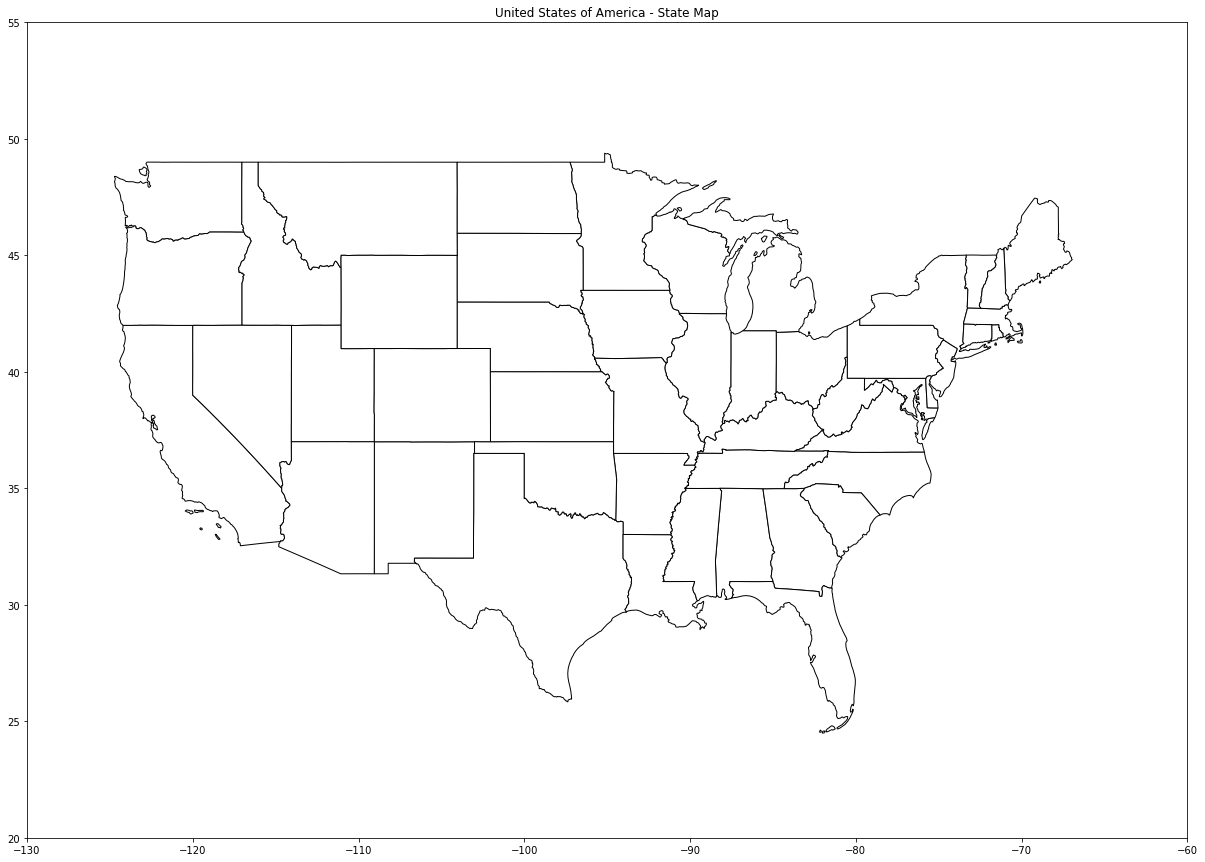

In [33]:
#Create map for USA - States
geo_usa_state.plot(figsize=(25, 15), facecolor="white", edgecolor="black")
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('United States of America - State Map');

In [34]:
#Load the shape file for "county map" using geopandas
geo_usa_county = gpd.read_file('https://github.com/oke-w/election_2020/raw/main/cb_2018_us_county_20m.zip')
geo_usa_county.drop(['COUNTYNS','AFFGEOID','GEOID','ALAND','AWATER'], axis='columns', inplace=True)
geo_usa_county

STATEFP COUNTYFP      NAME LSAD  \
0         37      017    Bladen   06   
1         37      167    Stanly   06   
2         39      153    Summit   06   
3         42      113  Sullivan   06   
4         48      459    Upshur   06   
...      ...      ...       ...  ...   
3215      38      005    Benson   06   
3216      72      079     Lajas   13   
3217      31      159    Seward   06   
3218      37      023     Burke   06   
3219      13      261    Sumter   06   

                                               geometry  
0     POLYGON ((-78.90200 34.83527, -78.79960 34.850...  
1     POLYGON ((-80.49737 35.20210, -80.29542 35.502...  
2     POLYGON ((-81.68699 41.13596, -81.68495 41.277...  
3     POLYGON ((-76.81373 41.59003, -76.22014 41.541...  
4     POLYGON ((-95.15274 32.66095, -95.15211 32.902...  
...                                                 ...  
3215  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  
3216  POLYGON ((-67.10904 18.05608, -67.06791 18.066...  
3217  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  
3218  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  
3219  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  

[3220 rows x 5 columns]

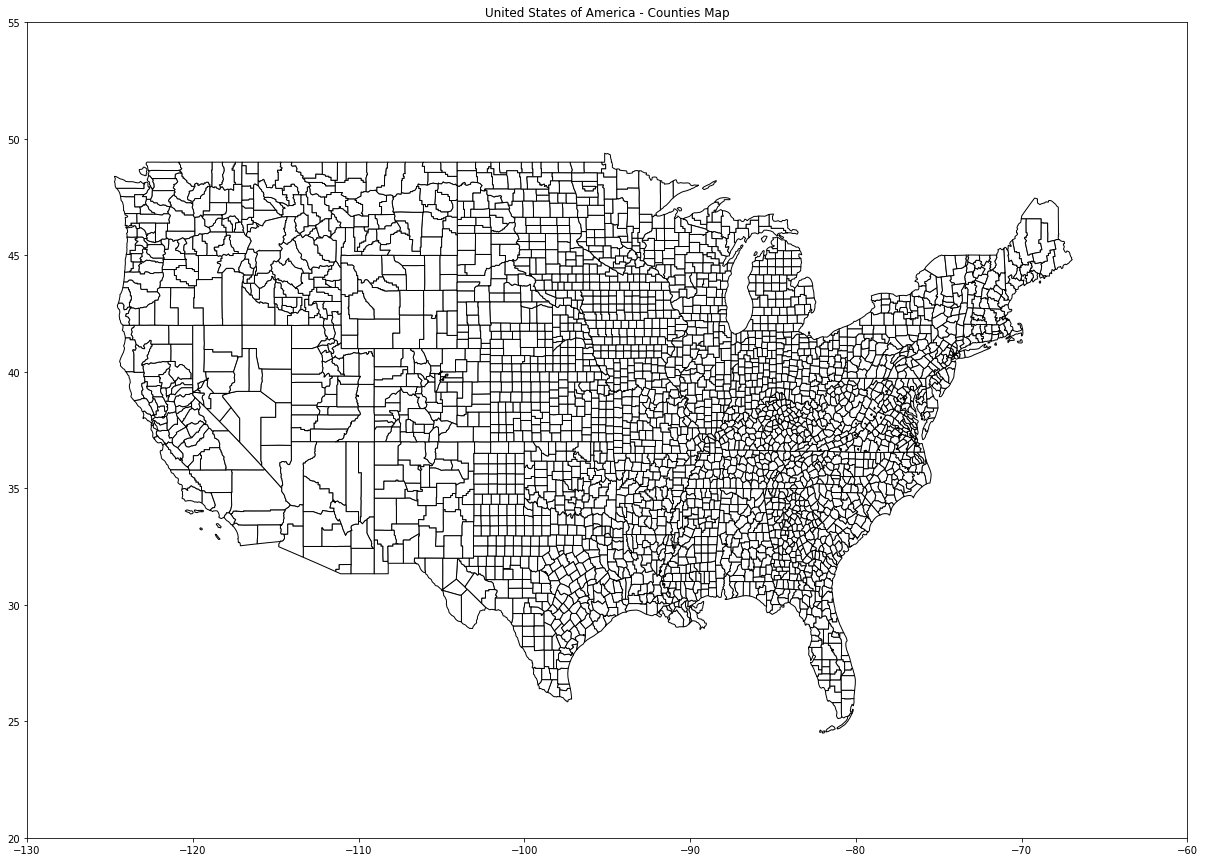

In [35]:
#Create map for USA - States
geo_usa_county.plot(figsize=(25, 15), facecolor="white", edgecolor="black")
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('United States of America - Counties Map');

In [36]:
#Add postfix "County" to match dataset
geo_usa_county['NAME'] = geo_usa_county['NAME'].astype(str) + ' County'
geo_usa_county

STATEFP COUNTYFP             NAME LSAD  \
0         37      017    Bladen County   06   
1         37      167    Stanly County   06   
2         39      153    Summit County   06   
3         42      113  Sullivan County   06   
4         48      459    Upshur County   06   
...      ...      ...              ...  ...   
3215      38      005    Benson County   06   
3216      72      079     Lajas County   13   
3217      31      159    Seward County   06   
3218      37      023     Burke County   06   
3219      13      261    Sumter County   06   

                                               geometry  
0     POLYGON ((-78.90200 34.83527, -78.79960 34.850...  
1     POLYGON ((-80.49737 35.20210, -80.29542 35.502...  
2     POLYGON ((-81.68699 41.13596, -81.68495 41.277...  
3     POLYGON ((-76.81373 41.59003, -76.22014 41.541...  
4     POLYGON ((-95.15274 32.66095, -95.15211 32.902...  
...                                                 ...  
3215  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  
3216  POLYGON ((-67.10904 18.05608, -67.06791 18.066...  
3217  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  
3218  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  
3219  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  

[3220 rows x 5 columns]

**Get latitude and longitude data for all states and counties**

In [37]:
#Read "uscities" file to get latitude and longitude information
lat_long_US_cities = pd.read_csv('https://github.com/oke-w/election_2020/raw/main/uscities.csv')
#lat_long_US_cities.head(5)

#Keep only required columns:
lat_long_US_states_counties = lat_long_US_cities[['state_id','state_name', 'county_name', 'lat', 'lng']]
lat_long_US_states_counties

state_id  state_name  county_name      lat       lng
0           NY    New York     New York  40.6943  -73.9249
1           CA  California  Los Angeles  34.1139 -118.4068
2           IL    Illinois         Cook  41.8373  -87.6862
3           FL     Florida   Miami-Dade  25.7839  -80.2102
4           TX       Texas       Dallas  32.7936  -96.7662
...        ...         ...          ...      ...       ...
28333       NE    Nebraska         Boyd  42.9461  -98.5697
28334       OK    Oklahoma        Tulsa  36.1334  -96.2091
28335       MN   Minnesota     Mahnomen  47.3198  -95.6952
28336       OK    Oklahoma        Creek  35.9113  -96.5772
28337       NE    Nebraska         Boyd  42.8307  -98.3296

[28338 rows x 5 columns]

In [38]:
#Append county_name with "County" so that it matches with our dataset and drop duplicated values of state and county names
lat_long_US_states_counties['county_name'] = lat_long_US_states_counties['county_name'].astype(str) + ' County'
lat_long_US_states_counties = lat_long_US_states_counties.drop_duplicates(subset=['state_name', 'county_name'], keep='last')
lat_long_US_states_counties

state_id            state_name                  county_name      lat  \
5           PA          Pennsylvania          Philadelphia County  40.0077   
8           DC  District of Columbia  District of Columbia County  38.9047   
12          CA            California         San Francisco County  37.7562   
17          CO              Colorado                Denver County  39.7621   
18          NY              New York                 Kings County  40.6501   
...        ...                   ...                          ...      ...   
28332       AK                Alaska            Dillingham County  58.9051   
28334       OK              Oklahoma                 Tulsa County  36.1334   
28335       MN             Minnesota              Mahnomen County  47.3198   
28336       OK              Oklahoma                 Creek County  35.9113   
28337       NE              Nebraska                  Boyd County  42.8307   

            lng  
5      -75.1339  
8      -77.0163  
12    -122.4430  
17    -104.8759  
18     -73.9496  
...         ...  
28332 -157.6695  
28334  -96.2091  
28335  -95.6952  
28336  -96.5772  
28337  -98.3296  

[3203 rows x 5 columns]

In [39]:
#Test:
lat_long_US_states_counties[lat_long_US_states_counties['county_name'] == 'Lee County'].count()

state_id       12
state_name     12
county_name    12
lat            12
lng            12
dtype: int64

In [40]:
#Add state name to the geo dataframe so that we can map County information in our dataset accurately as:
#County name + State name
geo_usa_county_new = geo_usa_county.merge(geo_usa_state[['STATEFP', 'NAME']],
                     left_on=['STATEFP'],
                     right_on=['STATEFP'],
                     suffixes=('_c', '_s'))
geo_usa_county_new = geo_usa_county_new.rename(columns={'NAME_c' : 'NAME'})
geo_usa_county_new

STATEFP COUNTYFP               NAME LSAD  \
0         37      017      Bladen County   06   
1         37      167      Stanly County   06   
2         37      105         Lee County   06   
3         37      007       Anson County   06   
4         37      185      Warren County   06   
...      ...      ...                ...  ...   
3215      09      009   New Haven County   06   
3216      09      007   Middlesex County   06   
3217      10      003  New Castle County   06   
3218      10      001        Kent County   06   
3219      10      005      Sussex County   06   

                                               geometry          NAME_s  
0     POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  
1     POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  
2     POLYGON ((-79.35007 35.51800, -79.24466 35.569...  North Carolina  
3     POLYGON ((-80.27683 35.19572, -80.17282 35.147...  North Carolina  
4     POLYGON ((-78.32372 36.54242, -78.13291 36.543...  North Carolina  
...                                                 ...             ...  
3215  POLYGON ((-73.31889 41.50519, -73.25226 41.512...     Connecticut  
3216  POLYGON ((-72.75218 41.57889, -72.71454 41.604...     Connecticut  
3217  POLYGON ((-75.77379 39.72220, -75.75323 39.757...        Delaware  
3218  POLYGON ((-75.76044 39.29679, -75.71490 39.299...        Delaware  
3219  POLYGON ((-75.72310 38.82983, -75.55501 38.835...        Delaware  

[3220 rows x 6 columns]

## Governor Data Set

### 1) Data analysis of "Governor votes dataset"

In [41]:
# Import data for vote count based on Governor dataset
votes_governor = pd.read_csv('https://github.com/oke-w/election_2020/blob/main/governors_county_candidate_2020_kaggle.csv?raw=true')

In [42]:
votes_governor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      5145 non-null   object
 1   county     5145 non-null   object
 2   candidate  5145 non-null   object
 3   party      5145 non-null   object
 4   votes      5145 non-null   int64 
 5   won        5145 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 206.1+ KB


In [43]:
# Retrieve the first 5 rows
votes_governor.head()

state             county        candidate party   votes    won
0  Delaware        Kent County      John Carney   DEM   44352   True
1  Delaware        Kent County  Julianne Murray   REP   39332  False
2  Delaware        Kent County  Kathy DeMatteis   IPD    1115  False
3  Delaware        Kent County    John Machurek   LIB     616  False
4  Delaware  New Castle County      John Carney   DEM  191678   True

In [44]:
# Check the no. of records
print('We have\033[1m {} \033[0mrecords in the governor dataset.'.format(len(votes_governor)))

We have 5145 records in the governor dataset.


In [45]:
# Check the no. of records as per state and county:
len(votes_governor[['state', 'county', 'candidate']].drop_duplicates())

5145

In [46]:
#Check no. of parties involved in governor dataset:
len(votes_governor[['party']].drop_duplicates())

12

In [47]:
#List the different parties for "Governor election"
print(votes_governor.party.unique())

['DEM' 'REP' 'IPD' 'LIB' 'GRN' 'WRI' 'CST' 'IAP' 'IND' 'TM' 'UNA' 'MNP']


### 2)  Calculate "Democratic, Republican and Other party votes"

**First, let's create a dataframe of votes other than "DEM and REP" by state and county**

In [48]:
#Calculate the number of 'other' votes for each county (not "REP or DEM")
votes_gov_other = votes_governor.pivot(index=['state', 'county', 'candidate'], columns="party", values='votes')
votes_gov_other = votes_gov_other.groupby(["state", "county"]).sum()
votes_gov_other

party                            CST       DEM  GRN  IAP  IND     IPD  \
state         county                                                    
Delaware      Kent County        0.0   44352.0  0.0  0.0  0.0  1115.0   
              New Castle County  0.0  191678.0  0.0  0.0  0.0  3785.0   
              Sussex County      0.0   56873.0  0.0  0.0  0.0  1250.0   
Indiana       Adams County       0.0    2143.0  0.0  0.0  0.0     0.0   
              Allen County       0.0   53895.0  0.0  0.0  0.0     0.0   
...                              ...       ...  ...  ...  ...     ...   
West Virginia Webster County     0.0     659.0  0.0  0.0  0.0     0.0   
              Wetzel County      0.0    1727.0  0.0  0.0  0.0     0.0   
              Wirt County        0.0     483.0  0.0  0.0  0.0     0.0   
              Wood County        0.0    9933.0  0.0  0.0  0.0     0.0   
              Wyoming County     0.0    1240.0  0.0  0.0  0.0     0.0   

party                                LIB    MNP      REP   TM  UNA    WRI  
state         county                                                       
Delaware      Kent County          616.0    0.0  39332.0  0.0  0.0    0.0  
              New Castle County   2031.0    0.0  82545.0  0.0  0.0    0.0  
              Sussex County        623.0    0.0  68435.0  0.0  0.0    0.0  
Indiana       Adams County        2570.0    0.0   9441.0  0.0  0.0    0.0  
              Allen County       16011.0    0.0  98406.0  0.0  0.0    0.0  
...                                  ...    ...      ...  ...  ...    ...  
West Virginia Webster County        88.0   40.0   2552.0  0.0  0.0    0.0  
              Wetzel County        180.0   87.0   4559.0  0.0  0.0    0.0  
              Wirt County           71.0   43.0   1947.0  0.0  0.0    0.0  
              Wood County         1071.0  380.0  26232.0  0.0  0.0  819.0  
              Wyoming County        86.0   53.0   6941.0  0.0  0.0    0.0  

[1025 rows x 12 columns]

In [49]:
#Keep all votes other than DEM and REP:
votes_gov_other.drop(['DEM', 'REP'], axis=1, inplace=True)
votes_gov_other['Other'] = votes_gov_other[list(votes_gov_other.columns)].sum(axis=1)
votes_gov_other

party                            CST  GRN  IAP  IND     IPD      LIB    MNP  \
state         county                                                          
Delaware      Kent County        0.0  0.0  0.0  0.0  1115.0    616.0    0.0   
              New Castle County  0.0  0.0  0.0  0.0  3785.0   2031.0    0.0   
              Sussex County      0.0  0.0  0.0  0.0  1250.0    623.0    0.0   
Indiana       Adams County       0.0  0.0  0.0  0.0     0.0   2570.0    0.0   
              Allen County       0.0  0.0  0.0  0.0     0.0  16011.0    0.0   
...                              ...  ...  ...  ...     ...      ...    ...   
West Virginia Webster County     0.0  0.0  0.0  0.0     0.0     88.0   40.0   
              Wetzel County      0.0  0.0  0.0  0.0     0.0    180.0   87.0   
              Wirt County        0.0  0.0  0.0  0.0     0.0     71.0   43.0   
              Wood County        0.0  0.0  0.0  0.0     0.0   1071.0  380.0   
              Wyoming County     0.0  0.0  0.0  0.0     0.0     86.0   53.0   

party                             TM  UNA    WRI    Other  
state         county                                       
Delaware      Kent County        0.0  0.0    0.0   1731.0  
              New Castle County  0.0  0.0    0.0   5816.0  
              Sussex County      0.0  0.0    0.0   1873.0  
Indiana       Adams County       0.0  0.0    0.0   2570.0  
              Allen County       0.0  0.0    0.0  16011.0  
...                              ...  ...    ...      ...  
West Virginia Webster County     0.0  0.0    0.0    128.0  
              Wetzel County      0.0  0.0    0.0    267.0  
              Wirt County        0.0  0.0    0.0    114.0  
              Wood County        0.0  0.0  819.0   2270.0  
              Wyoming County     0.0  0.0    0.0    139.0  

[1025 rows x 11 columns]

In [50]:
votes_gov_other

party                            CST  GRN  IAP  IND     IPD      LIB    MNP  \
state         county                                                          
Delaware      Kent County        0.0  0.0  0.0  0.0  1115.0    616.0    0.0   
              New Castle County  0.0  0.0  0.0  0.0  3785.0   2031.0    0.0   
              Sussex County      0.0  0.0  0.0  0.0  1250.0    623.0    0.0   
Indiana       Adams County       0.0  0.0  0.0  0.0     0.0   2570.0    0.0   
              Allen County       0.0  0.0  0.0  0.0     0.0  16011.0    0.0   
...                              ...  ...  ...  ...     ...      ...    ...   
West Virginia Webster County     0.0  0.0  0.0  0.0     0.0     88.0   40.0   
              Wetzel County      0.0  0.0  0.0  0.0     0.0    180.0   87.0   
              Wirt County        0.0  0.0  0.0  0.0     0.0     71.0   43.0   
              Wood County        0.0  0.0  0.0  0.0     0.0   1071.0  380.0   
              Wyoming County     0.0  0.0  0.0  0.0     0.0     86.0   53.0   

party                             TM  UNA    WRI    Other  
state         county                                       
Delaware      Kent County        0.0  0.0    0.0   1731.0  
              New Castle County  0.0  0.0    0.0   5816.0  
              Sussex County      0.0  0.0    0.0   1873.0  
Indiana       Adams County       0.0  0.0    0.0   2570.0  
              Allen County       0.0  0.0    0.0  16011.0  
...                              ...  ...    ...      ...  
West Virginia Webster County     0.0  0.0    0.0    128.0  
              Wetzel County      0.0  0.0    0.0    267.0  
              Wirt County        0.0  0.0    0.0    114.0  
              Wood County        0.0  0.0  819.0   2270.0  
              Wyoming County     0.0  0.0    0.0    139.0  

[1025 rows x 11 columns]

**Second, let's combine DEM & REP along with the Other votes calculated above**

In [51]:
#Keep only records for DEM and REP parties:
votes_gov = votes_gov_other.groupby(["state", "county"]).sum()
votes_gov = votes_governor.loc[votes_governor.party.isin(['DEM', 'REP'])]
votes_gov.drop(['candidate'], axis=1, inplace=True)
votes_gov

state             county party   votes    won
0          Delaware        Kent County   DEM   44352   True
1          Delaware        Kent County   REP   39332  False
4          Delaware  New Castle County   DEM  191678   True
5          Delaware  New Castle County   REP   82545  False
8          Delaware      Sussex County   REP   68435   True
...             ...                ...   ...     ...    ...
5132  West Virginia        Wirt County   DEM     483  False
5135  West Virginia        Wood County   REP   26232   True
5136  West Virginia        Wood County   DEM    9933  False
5140  West Virginia     Wyoming County   REP    6941   True
5141  West Virginia     Wyoming County   DEM    1240  False

[2050 rows x 5 columns]

In [52]:
#Convert the data so that there is one row per county
votes_gov = votes_gov.pivot(index=['state', 'county'], columns="party", values=['votes', 'won'])

#Add the number of votes for "other" candidates in each county
votes_gov['votes', 'Other'] = votes_gov_other['Other'].astype('int')

#Sort the index
votes_gov.sort_index(axis=1, inplace=True)
#votes_gov.reset_index(inplace=True)
votes_gov

votes                  won       
party                               DEM  Other    REP    DEM    REP
state         county                                               
Delaware      Kent County         44352   1731  39332   True  False
              New Castle County  191678   5816  82545   True  False
              Sussex County       56873   1873  68435  False   True
Indiana       Adams County         2143   2570   9441  False   True
              Allen County        53895  16011  98406  False   True
...                                 ...    ...    ...    ...    ...
West Virginia Webster County        659    128   2552  False   True
              Wetzel County        1727    267   4559  False   True
              Wirt County           483    114   1947  False   True
              Wood County          9933   2270  26232  False   True
              Wyoming County       1240    139   6941  False   True

[1025 rows x 5 columns]

In [53]:
#Set columns names
votes_gov.columns = ['votes_DEM', 'votes_oth', 'votes_REP', 'won_DEM', 'won_REP']
votes_gov = votes_gov.convert_dtypes()
votes_gov

votes_DEM  votes_oth  votes_REP  won_DEM  \
state         county                                                        
Delaware      Kent County            44352       1731      39332     True   
              New Castle County     191678       5816      82545     True   
              Sussex County          56873       1873      68435    False   
Indiana       Adams County            2143       2570       9441    False   
              Allen County           53895      16011      98406    False   
...                                    ...        ...        ...      ...   
West Virginia Webster County           659        128       2552    False   
              Wetzel County           1727        267       4559    False   
              Wirt County              483        114       1947    False   
              Wood County             9933       2270      26232    False   
              Wyoming County          1240        139       6941    False   

                                 won_REP  
state         county                      
Delaware      Kent County          False  
              New Castle County    False  
              Sussex County         True  
Indiana       Adams County          True  
              Allen County          True  
...                                  ...  
West Virginia Webster County        True  
              Wetzel County         True  
              Wirt County           True  
              Wood County           True  
              Wyoming County        True  

[1025 rows x 5 columns]

----

# Linear Regression: Voter Turnout (Wes)

In [54]:
votes_ccpt.columns

Index(['state', 'county', 'votes_tru', 'votes_bid', 'votes_oth', 'won_tru',
       'won_bid', 'votes_tot', 'pct_tru', 'pct_bid', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE',
       'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'child', 'yg_adlt', 'mid_age', 'senior', 'child_m',
       'yg_adlt_m', 'mid_age_m', 'senior_m', 'child_f', 'yg_adlt_f',
       'mid_age_f', 'senior_f', 'rural_urban_code', 'urban_infl_code',
       'pop_chg', 'r_birth', 'r_death', 'r_natl_increase', 'r_intl_mig',
       'r_domest_mig', 'r_net_mig', 'metro', 'econ_type_code',
       'econ_type_name', 'econ_farming', 'econ_mining', 'econ_manufacturing',
       'econ_government', 'econ_recreation', 'econ_nonspecialized',
       'low_education', 'low_employment', 'pop_loss', 'retirement_dest',
       'poverty', 'child_poverty', 'pct_tot'],
      dtype='object')

In [55]:
# Combine the ethnicity (race) male/female data together:
turnout = pd.DataFrame()
turnout['pct_tot'] = votes_ccpt['pct_tot']
turnout['pct_diff'] = (votes_ccpt['pct_tru'] - votes_ccpt['pct_bid']).abs()

# Normalize the population-based columns by the total population:
cols_in = ['TOT_MALE', 'TOT_FEMALE']
cols_out = ['pct_MALE', 'pct_FEMALE']
for n, c in enumerate(cols_out):
    turnout[c] = votes_ccpt[cols_in[n]] / votes_ccpt['TOT_POP']

cols_in_a = ['WA_MALE', 'BAC_MALE', 'IAC_MALE', 'AAC_MALE', 'H_MALE']
cols_in_b = ['WA_FEMALE', 'BAC_FEMALE', 'IAC_FEMALE', 'AAC_FEMALE', 'H_FEMALE']
cols_out = ['pct_WA','pct_BAC', 'pct_IAC', 'pct_AAC', 'pct_H']
for n, c in enumerate(cols_out):
    turnout[c] = (votes_ccpt[cols_in_a[n]] + votes_ccpt[cols_in_b[n]]) / votes_ccpt['TOT_POP']

cols_in = ['child', 'yg_adlt', 'mid_age', 'senior']
cols_out = ['pct_child', 'pct_yg_adlt', 'pct_mid_age', 'pct_senior']
for n, c in enumerate(cols_out):
    turnout[c] = votes_ccpt[cols_in[n]] / votes_ccpt['TOT_POP']

cols = ['urban_infl_code', 'metro', 'econ_farming', 'econ_mining', 'econ_manufacturing',
       'econ_government', 'econ_recreation', 'econ_nonspecialized',
       'low_education', 'low_employment', 'pop_loss', 'retirement_dest',
       'poverty', 'child_poverty']
turnout[cols] = votes_ccpt[cols]

turnout.head()

pct_tot  pct_diff  pct_MALE  pct_FEMALE    pct_WA   pct_BAC   pct_IAC  \
0  0.644615  0.444184  0.484920    0.515080  0.762623  0.210922  0.010292   
1  0.622472  0.537623  0.484904    0.515096  0.874410  0.095657  0.016140   
2  0.535240  0.076631  0.529207    0.470793  0.491534  0.490845  0.012031   
3  0.535645  0.577280  0.532687    0.467313  0.767661  0.219121  0.009244   
4  0.616657  0.800022  0.492374    0.507626  0.958254  0.022066  0.014180   

    pct_AAC     pct_H  pct_child  ...  econ_manufacturing  econ_government  \
0  0.017004  0.029909   0.228893  ...                   0                0   
1  0.015011  0.047188   0.210694  ...                   0                0   
2  0.006157  0.045248   0.203921  ...                   1                0   
3  0.004332  0.027820   0.200054  ...                   0                0   
4  0.005395  0.096531   0.226317  ...                   0                0   

   econ_recreation  econ_nonspecialized  low_education  low_employment  \
0                0                    1              0               0   
1                1                    0              0               0   
2                0                    0              1               1   
3                0                    1              1               1   
4                0                    1              1               1   

   pop_loss  retirement_dest  poverty  child_poverty  
0         0                1        0              0  
1         0                1        0              0  
2         0                0        1              1  
3         0                0        0              1  
4         0                0        0              0  

[5 rows x 27 columns]

In [56]:
# first, we will assess the columns' correlation with the target variable to
# identify suitable predictors
turnout.corr().iloc[0]

pct_tot                1.000000
pct_diff              -0.104888
pct_MALE              -0.238823
pct_FEMALE             0.238823
pct_WA                 0.248800
pct_BAC               -0.192406
pct_IAC               -0.149683
pct_AAC               -0.014806
pct_H                 -0.370072
pct_child             -0.291130
pct_yg_adlt           -0.475806
pct_mid_age            0.152008
pct_senior             0.466545
urban_infl_code        0.030458
metro                  0.070991
econ_farming           0.139354
econ_mining           -0.126849
econ_manufacturing    -0.051712
econ_government       -0.208532
econ_recreation        0.291280
econ_nonspecialized   -0.025124
low_education         -0.421804
low_employment        -0.307071
pop_loss               0.086426
retirement_dest        0.087558
poverty               -0.271675
child_poverty         -0.346206
Name: pct_tot, dtype: float64

In [57]:
# initially, we will select linear regression features that have a correlation magnitude with y of at least ~0.2:
x_all = ['pct_MALE', 'pct_FEMALE', 'pct_WA', 'pct_BAC', 'pct_H', 'pct_child', 'pct_yg_adlt', 'pct_senior',
         'econ_government', 'econ_recreation', 'low_education', 'low_employment', 'poverty', 'child_poverty']
turnout_R2_dict = {}
for x in x_all:
    form = 'pct_tot ~ {}'.format(x)
    temp_model = sm.ols(formula=form, data=turnout).fit()
    turnout_R2_dict[x] = temp_model.rsquared
    print(x, '{:.3f}'.format(temp_model.rsquared))

pct_MALE 0.057
pct_FEMALE 0.057
pct_WA 0.062
pct_BAC 0.037
pct_H 0.137
pct_child 0.085
pct_yg_adlt 0.226
pct_senior 0.218
econ_government 0.043
econ_recreation 0.085
low_education 0.178
low_employment 0.094
poverty 0.074
child_poverty 0.120


In [58]:
turnout_R2 = pd.Series(turnout_R2_dict).sort_values()
turnout_R2.rename(index={'pct_yg_adlt':'% of Young Adults',
                           'pct_senior': '% of Seniors',
                           'low_education': 'Low Education Flag',
                           'pct_H': '% of Hispanics',
                           'child_poverty': 'Child Poverty Flag',
                           'low_employment': 'Low Employment Flag'},inplace=True)

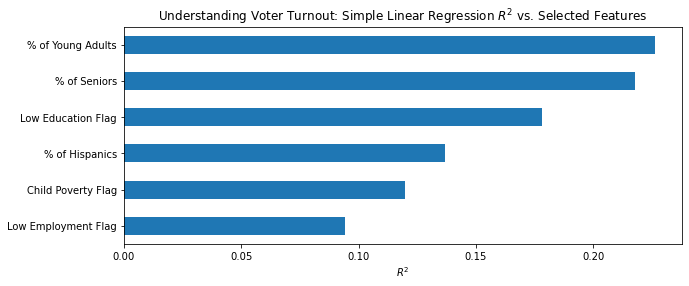

In [59]:
#print(turnout_R2)
fig = plt.figure(figsize=(10,4))
turnout_R2.iloc[-6:].plot.barh()
plt.title('Understanding Voter Turnout: Simple Linear Regression $R^2$ vs. Selected Features')
plt.xlabel('$R^2$');

In [60]:
# investigate if features correlated together (colinear)
turnout[x_all].corr()[turnout[x_all].corr().abs() > 0.3]

pct_MALE  pct_FEMALE    pct_WA   pct_BAC     pct_H  \
pct_MALE              1.0        -1.0       NaN       NaN       NaN   
pct_FEMALE           -1.0         1.0       NaN       NaN       NaN   
pct_WA                NaN         NaN  1.000000 -0.868607       NaN   
pct_BAC               NaN         NaN -0.868607  1.000000       NaN   
pct_H                 NaN         NaN       NaN       NaN  1.000000   
pct_child             NaN         NaN       NaN       NaN  0.318525   
pct_yg_adlt           NaN         NaN -0.311010       NaN       NaN   
pct_senior            NaN         NaN       NaN       NaN       NaN   
econ_government       NaN         NaN       NaN       NaN       NaN   
econ_recreation       NaN         NaN       NaN       NaN       NaN   
low_education         NaN         NaN       NaN       NaN  0.346515   
low_employment        NaN         NaN       NaN       NaN       NaN   
poverty               NaN         NaN -0.451716  0.425439       NaN   
child_poverty         NaN         NaN -0.458363  0.441158       NaN   

                 pct_child  pct_yg_adlt  pct_senior  econ_government  \
pct_MALE               NaN          NaN         NaN              NaN   
pct_FEMALE             NaN          NaN         NaN              NaN   
pct_WA                 NaN    -0.311010         NaN              NaN   
pct_BAC                NaN          NaN         NaN              NaN   
pct_H             0.318525          NaN         NaN              NaN   
pct_child         1.000000     0.304735   -0.681002              NaN   
pct_yg_adlt       0.304735     1.000000   -0.822948         0.341756   
pct_senior       -0.681002    -0.822948    1.000000              NaN   
econ_government        NaN     0.341756         NaN         1.000000   
econ_recreation  -0.383686          NaN    0.394694              NaN   
low_education          NaN          NaN         NaN              NaN   
low_employment         NaN          NaN         NaN              NaN   
poverty                NaN          NaN         NaN              NaN   
child_poverty          NaN          NaN         NaN              NaN   

                 econ_recreation  low_education  low_employment   poverty  \
pct_MALE                     NaN            NaN             NaN       NaN   
pct_FEMALE                   NaN            NaN             NaN       NaN   
pct_WA                       NaN            NaN             NaN -0.451716   
pct_BAC                      NaN            NaN             NaN  0.425439   
pct_H                        NaN       0.346515             NaN       NaN   
pct_child              -0.383686            NaN             NaN       NaN   
pct_yg_adlt                  NaN            NaN             NaN       NaN   
pct_senior              0.394694            NaN             NaN       NaN   
econ_government              NaN            NaN             NaN       NaN   
econ_recreation         1.000000            NaN             NaN       NaN   
low_education                NaN       1.000000        0.367449  0.405478   
low_employment               NaN       0.367449        1.000000  0.412917   
poverty                      NaN       0.405478        0.412917  1.000000   
child_poverty                NaN       0.404772        0.486032  0.643602   

                 child_poverty  
pct_MALE                   NaN  
pct_FEMALE                 NaN  
pct_WA               -0.458363  
pct_BAC               0.441158  
pct_H                      NaN  
pct_child                  NaN  
pct_yg_adlt                NaN  
pct_senior                 NaN  
econ_government            NaN  
econ_recreation            NaN  
low_education         0.404772  
low_employment        0.486032  
poverty               0.643602  
child_poverty         1.000000

To reduce the amount of colinearity, we will exclude pairs of features that have a correlation greater than 0.5, and will monitor pairs of features that have a correlation greater than 0.4

* We exclude female due to its high correlation with male
* We exclude senior due to its high correlation with yg_adlt
* We exclude either pct_BAC or pct_WA due to their high correlation with each other. Trial and error determined that pct_WA had a p value greater than 0.05, so it will be excluded.
* We exclude poverty due to its high correlation with child_poverty and lower correlation with y

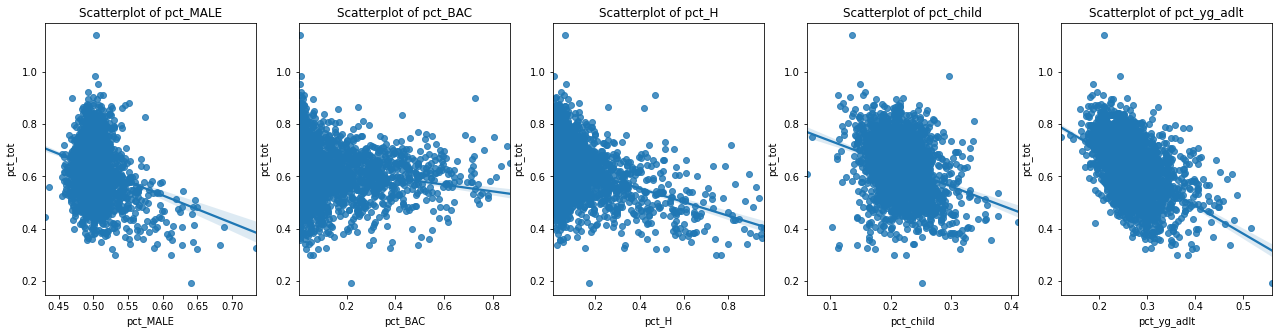

In [61]:
# plot 
x_num = ['pct_MALE', 'pct_BAC', 'pct_H', 'pct_child', 'pct_yg_adlt']
fig, axs = plt.subplots(1, 5, figsize=(22, 5))
for n, ax in enumerate(fig.get_axes()): # will return each set of axis in turn
    sns.regplot(x=turnout[x_num[n]], y=turnout['pct_tot'], ax=ax)
    ax.set_title('Scatterplot of {}'.format(x_num[n]));

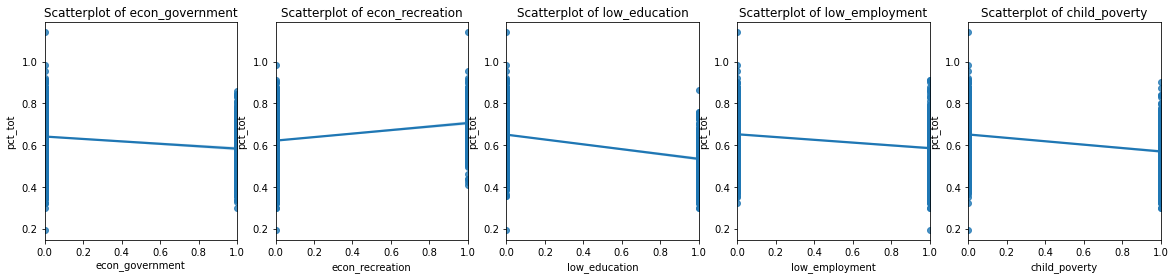

In [62]:
x_cat = ['econ_government', 'econ_recreation', 'low_education', 'low_employment', 'child_poverty']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for n, ax in enumerate(fig.get_axes()): # will return each set of axis in turn
    sns.regplot(x=turnout[x_cat[n]], y=turnout['pct_tot'], ax=ax);
    ax.set_title('Scatterplot of {}'.format(x_cat[n]))

In [63]:
# to reduce the amount of colinearity, we will exclude pairs of features that have a correlation greater than 0.5, and will monitor pairs of features that have a correlation greater than 0.4
# we therefore keep one age groups (child, yg_adlt, or senior).  Keep yg_adlt as it has the highest correlation with y
# we will exclude pct_WA due to its high correlation with pct_BAC, child poverty, and moderate correlation with pct_yg_adlt
# we will exclude poverty due to its high correlation with child_poverty and lower correlation with y
form = 'pct_tot ~ pct_MALE + pct_BAC + pct_H + pct_yg_adlt + pct_child + econ_government + econ_recreation + low_education + low_employment + child_poverty'

# and we will consider removing pct_WA due to its high correlation with child_poverty, and lower correlation with y
# we will also consider removing low_employment due to its high correlation with child_poverty, and lower correlation with y

turnout_model = sm.ols(formula=form, data=turnout).fit()
print(turnout_model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.493     
Dependent Variable: pct_tot          AIC:                -7719.1203
Date:               2021-04-09 23:48 BIC:                -7652.6507
No. Observations:   3111             Log-Likelihood:     3870.6    
Df Model:           10               F-statistic:        303.6     
Df Residuals:       3100             Prob (F-statistic): 0.00      
R-squared:          0.495            Scale:              0.0048798 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           1.1373   0.0357  31.8512 0.0000  1.0673  1.2073
pct_MALE           -0.3773   0.0666  -5.6664 0.0000 -0.5078 -0.2467
pct_BAC             0.0436   0.0108   4.0255 0.0001  0.0224  0.0649
pct_H              -0.1166   0.0106 -10.9764 0.0000 -0.1375 -0.095

In [64]:
# remove econ_government as it is not statistically significant
form = 'pct_tot ~ pct_MALE + pct_BAC + pct_H + pct_child + pct_yg_adlt + econ_recreation + low_education + low_employment + child_poverty'
turnout_model = sm.ols(formula=form, data=turnout).fit()
print(turnout_model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.493     
Dependent Variable: pct_tot          AIC:                -7720.0673
Date:               2021-04-09 23:48 BIC:                -7659.6403
No. Observations:   3111             Log-Likelihood:     3870.0    
Df Model:           9                F-statistic:        337.2     
Df Residuals:       3101             Prob (F-statistic): 0.00      
R-squared:          0.495            Scale:              0.0048799 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           1.1436   0.0352  32.5169 0.0000  1.0747  1.2126
pct_MALE           -0.3876   0.0658  -5.8903 0.0000 -0.5167 -0.2586
pct_BAC             0.0434   0.0108   4.0019 0.0001  0.0221  0.0646
pct_H              -0.1167   0.0106 -10.9834 0.0000 -0.1375 -0.095

## Check influence

To investigate outliers with high leverage, we will consider any data points where:
- the predicted y value is more than 3 studentized standard deviations away from the actual y value (ie. the studentized residual is > 3); and
- the point has high leverage, which will be measured as the value of H being greater than 3*(p/N), where p is the number of model parameters including intercept, and N is the number of observations.

In [65]:
p = turnout_model.params.shape[0]
N = turnout_model.nobs
H = 3 * p / N
print("H_max =", H)
turnout_infl_m = OLSInfluence(turnout_model)
turnout_infl = turnout_infl_m.summary_frame()
display(turnout_infl.loc[(abs(turnout_infl.student_resid) >= 3) & (turnout_infl.hat_diag > H)])

H_max = 0.009643201542912247


dfb_Intercept  dfb_pct_MALE  dfb_pct_BAC  dfb_pct_H  dfb_pct_child  \
1775       0.150428     -0.051584     0.014749   0.319702      -0.264343   

      dfb_pct_yg_adlt  dfb_econ_recreation  dfb_low_education  \
1775         -0.10569            -0.170613          -0.099317   

      dfb_low_employment  dfb_child_poverty   cooks_d  standard_resid  \
1775            0.107093          -0.071332  0.018255        3.704007   

      hat_diag  dffits_internal  student_resid    dffits  
1775  0.013131         0.427255       3.711629  0.428134

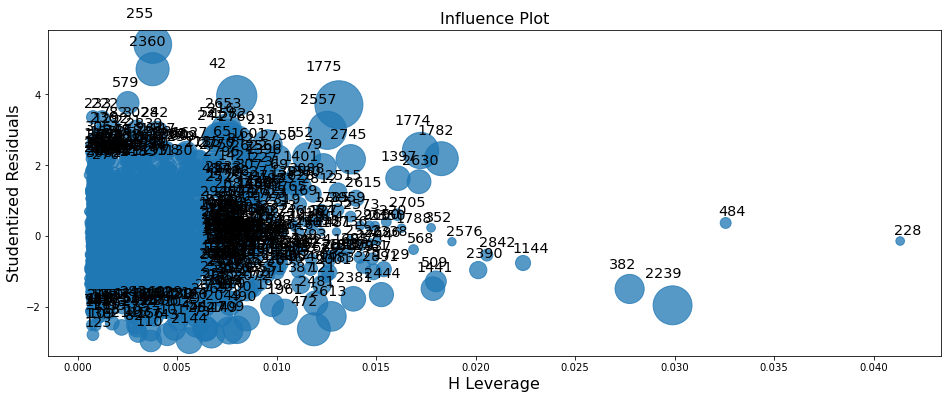

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
turnout_infl_m.plot_influence(ax=ax);

No points match the outlier / influence criteria.

## Check residuals

Check for the following conditions:
"Multiple regression methods [...] generally depend on the following four conditions:
1. the residuals of the model are nearly normal (less important for larger data sets),
2. the variability of the residuals is nearly constant,
3. the residuals are independent, and
4. each variable is linearly related to the outcome."

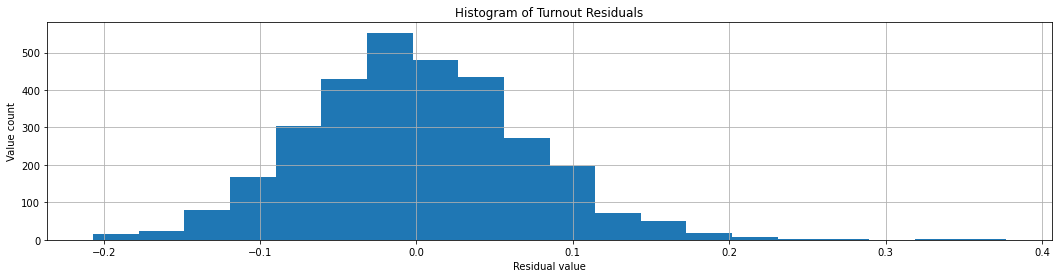

In [67]:
fig = turnout_model.resid.hist(bins=20, figsize=(18, 4));
fig.set(title='Histogram of Turnout Residuals', xlabel='Residual value',
       ylabel='Value count');

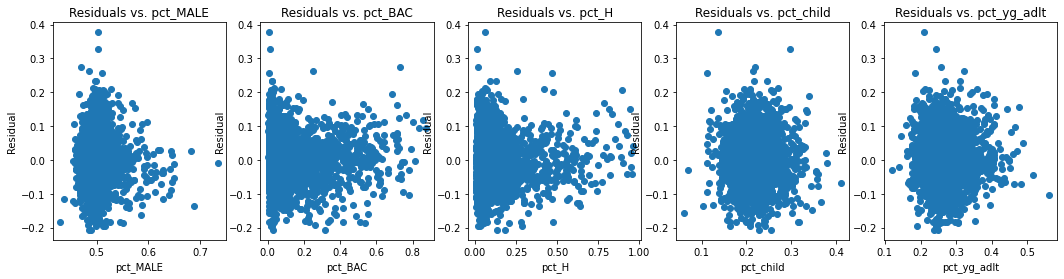

In [68]:
# check the residual distribution for numerical variables
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
for n, ax in enumerate(fig.get_axes()): # will return each set of axis in turn
    ax.scatter(turnout[x_num[n]], turnout_model.resid)
    ax.set_title('Residuals vs. {}'.format(x_num[n]))
    ax.set(xlabel=x_num[n], ylabel='Residual');

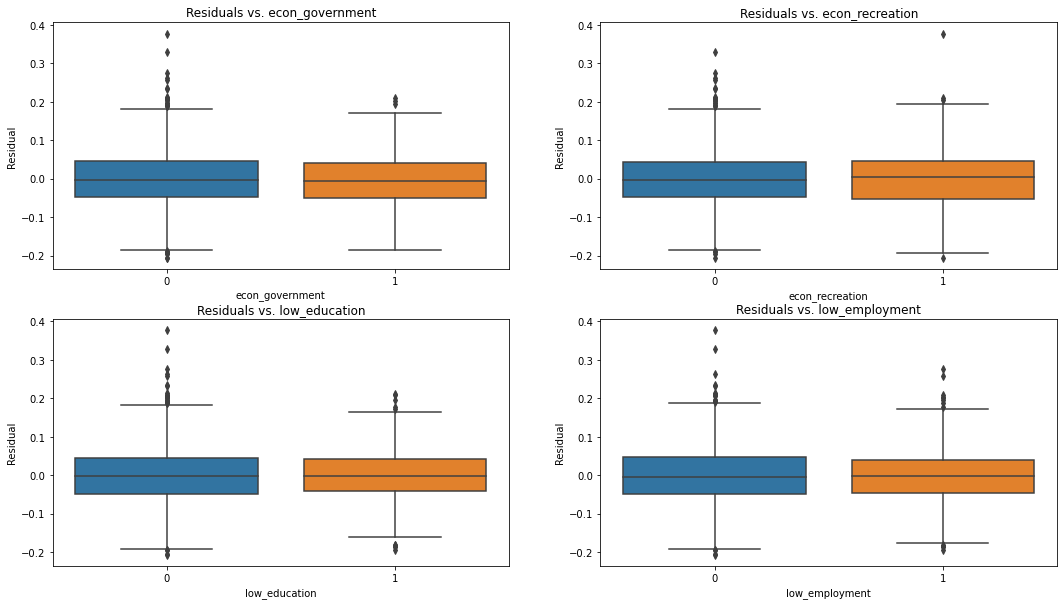

In [69]:
# check the residual distribution for categorical variables
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for n, ax in enumerate(fig.get_axes()): # will return each set of axis in turn
    sns.boxplot(x=turnout[x_cat[n]], y=turnout_model.resid, ax=ax)
    ax.set_title('Residuals vs. {}'.format(x_cat[n]))
    ax.set(xlabel=x_cat[n], ylabel='Residual');

# Logistic Regression: Estimate President Win Based On Ethnic Groups

In [70]:
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit
import matplotlib.pyplot as plt

In [71]:
votes_ccpt_copy = votes_ccpt.copy()
votes_ccpt_copy.head()

state          county  votes_tru  votes_bid  votes_oth  won_tru  won_bid  \
0  Alabama  Autauga County      19838       7503        429     True    False   
1  Alabama  Baldwin County      83544      24578       1557     True    False   
2  Alabama  Barbour County       5622       4816         80     True    False   
3  Alabama     Bibb County       7525       1986         84     True    False   
4  Alabama   Blount County      24711       2640        237     True    False   

   votes_tot   pct_tru   pct_bid  ...  econ_government  econ_recreation  \
0    27770.0  0.714368  0.270184  ...                0                0   
1   109679.0  0.761714  0.224090  ...                0                1   
2    10518.0  0.534512  0.457882  ...                0                0   
3     9595.0  0.784263  0.206983  ...                0                0   
4    27588.0  0.895716  0.095694  ...                0                0   

   econ_nonspecialized  low_education  low_employment  pop_loss  \
0                    1              0               0         0   
1                    0              0               0         0   
2                    0              1               1         0   
3                    1              1               1         0   
4                    1              1               1         0   

   retirement_dest  poverty  child_poverty   pct_tot  
0                1        0              0  0.644615  
1                1        0              0  0.622472  
2                0        1              1  0.535240  
3                0        0              1  0.535645  
4                0        0              0  0.616657  

[5 rows x 60 columns]

In [72]:
# dropna in won_tru and won_bid. This is necessary for the model. These 2 columns cannot contain NaN values.
votes_ccpt_copy = votes_ccpt_copy[votes_ccpt_copy['won_tru'].notna()]
votes_ccpt_copy = votes_ccpt_copy[votes_ccpt_copy['won_bid'].notna()]
votes_ccpt_copy['won_tru'].isnull().sum()
votes_ccpt_copy['won_bid'].isnull().sum()

0

In [73]:
# Change the boolean True/False in won_tru and won_bid to 1/0. The model only takes 1 and 0 (int, not any other types).
votes_ccpt_copy['won_tru'] = votes_ccpt_copy['won_tru'].astype(int)
votes_ccpt_copy['won_bid'] = votes_ccpt_copy['won_bid'].astype(int)
votes_ccpt_copy.head()

state          county  votes_tru  votes_bid  votes_oth  won_tru  won_bid  \
0  Alabama  Autauga County      19838       7503        429        1        0   
1  Alabama  Baldwin County      83544      24578       1557        1        0   
2  Alabama  Barbour County       5622       4816         80        1        0   
3  Alabama     Bibb County       7525       1986         84        1        0   
4  Alabama   Blount County      24711       2640        237        1        0   

   votes_tot   pct_tru   pct_bid  ...  econ_government  econ_recreation  \
0    27770.0  0.714368  0.270184  ...                0                0   
1   109679.0  0.761714  0.224090  ...                0                1   
2    10518.0  0.534512  0.457882  ...                0                0   
3     9595.0  0.784263  0.206983  ...                0                0   
4    27588.0  0.895716  0.095694  ...                0                0   

   econ_nonspecialized  low_education  low_employment  pop_loss  \
0                    1              0               0         0   
1                    0              0               0         0   
2                    0              1               1         0   
3                    1              1               1         0   
4                    1              1               1         0   

   retirement_dest  poverty  child_poverty   pct_tot  
0                1        0              0  0.644615  
1                1        0              0  0.622472  
2                0        1              1  0.535240  
3                0        0              1  0.535645  
4                0        0              0  0.616657  

[5 rows x 60 columns]

In [74]:
# Fit the model
predictors = ['WA_MALE', 'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']
m = Logit(votes_ccpt_copy['won_bid'], votes_ccpt_copy[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.514791
         Iterations 10


In [75]:
# resulting regression parameters
m.params  

WA_MALE      -0.000316
WA_FEMALE     0.000226
BAC_MALE     -0.000100
BAC_FEMALE    0.000149
IAC_MALE     -0.004021
IAC_FEMALE    0.003756
AAC_MALE      0.000380
AAC_FEMALE    0.000616
H_MALE       -0.000624
H_FEMALE      0.000708
dtype: float64

In [76]:
# model summary
print(m.summary2()) 

                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.177   
Dependent Variable: won_bid          AIC:              3154.0504
Date:               2021-04-09 23:48 BIC:              3214.2597
No. Observations:   3044             Log-Likelihood:   -1567.0  
Df Model:           9                LL-Null:          -1331.6  
Df Residuals:       3034             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     10.0000                                     
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
WA_MALE      -0.0003    0.0001  -5.3451  0.0000  -0.0004  -0.0002
WA_FEMALE     0.0002    0.0001   4.0360  0.0001   0.0001   0.0003
BAC_MALE     -0.0001    0.0001  -0.9337  0.3505  -0.0003   0.0001
BAC_FEMALE    0.0001    0.0001   1.6246  0.1

In [77]:
# derive the estimates of the odds
votes_ccpt_copy.loc[:, 'p'] = m.predict(votes_ccpt_copy[predictors])

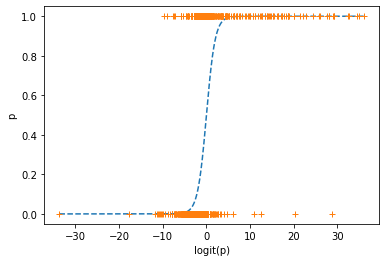

In [78]:
# plot the relationship between the values of logit(p) and the odds p along with the actual values of the response (won_bid)
votes_ccpt_copy = votes_ccpt_copy.sort_values(by = ['p'], axis = 0)
plt.plot(logit(votes_ccpt_copy.p), votes_ccpt_copy.p, '--')
plt.plot(logit(votes_ccpt_copy.p), votes_ccpt_copy.won_bid, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

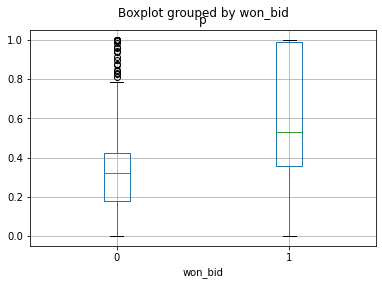

In [79]:
# plot a boxplot to see the distribution of the estimated odds for both values of the actual response
votes_ccpt_copy.boxplot(column='p', by = 'won_bid')
plt.show()

In [80]:
# derive the binary estimates yhat of the response y
votes_ccpt_copy.loc[:, 'yhat'] = (votes_ccpt_copy.p > 0.5) * 1
votes_ccpt_copy.yhat.value_counts()

0    2700
1     344
Name: yhat, dtype: int64

In [81]:
# create a confusion matrix to see how well our estimates match the actual values
pd.crosstab(votes_ccpt_copy.won_bid, votes_ccpt_copy.yhat)

yhat        0    1
won_bid           
0        2491   70
1         209  274

In the confusion matrix above, we see that we have 2491 cases where the county was correctly estimated to not be won by Biden and 274 cases where the county was correctly estimated to be won by Biden. The remaining 209 + 70 estimates were incorrect.

Conclusions: As we all know, Biden won in the presidential election last year. However, the logistic model based on 5 ethnic groups predicted otherwise (Biden not won). So, we can conclude that the predictors in this model (5 groups with genders) were not enough for predicting election results. Other factors, e.g. income, education level, etc., definitely play an important role in determining the results.

----

#   Governor vs Presidental Election Results: Vote Count and Race

### 1) Governor - Vote Count by State (DEM & REP Party)

In [82]:
votes_gov_by_state_and_party = votes_gov
votes_gov_by_state_and_party = votes_gov_by_state_and_party.reset_index()
votes_gov_by_state_and_party = votes_gov_by_state_and_party.groupby(['state'])[["votes_DEM", "votes_REP"]].sum()
votes_gov_by_state_and_party

votes_DEM  votes_REP
state                               
Delaware           292903     190312
Indiana            968092    1706724
Missouri          1225771    1720202
Montana            250860     328548
New Hampshire      264639     516609
North Carolina    2834790    2586604
North Dakota        90789     235479
Utah               442754     918754
Vermont             99214     248412
Washington        2294243    1749066
West Virginia      237024     497944

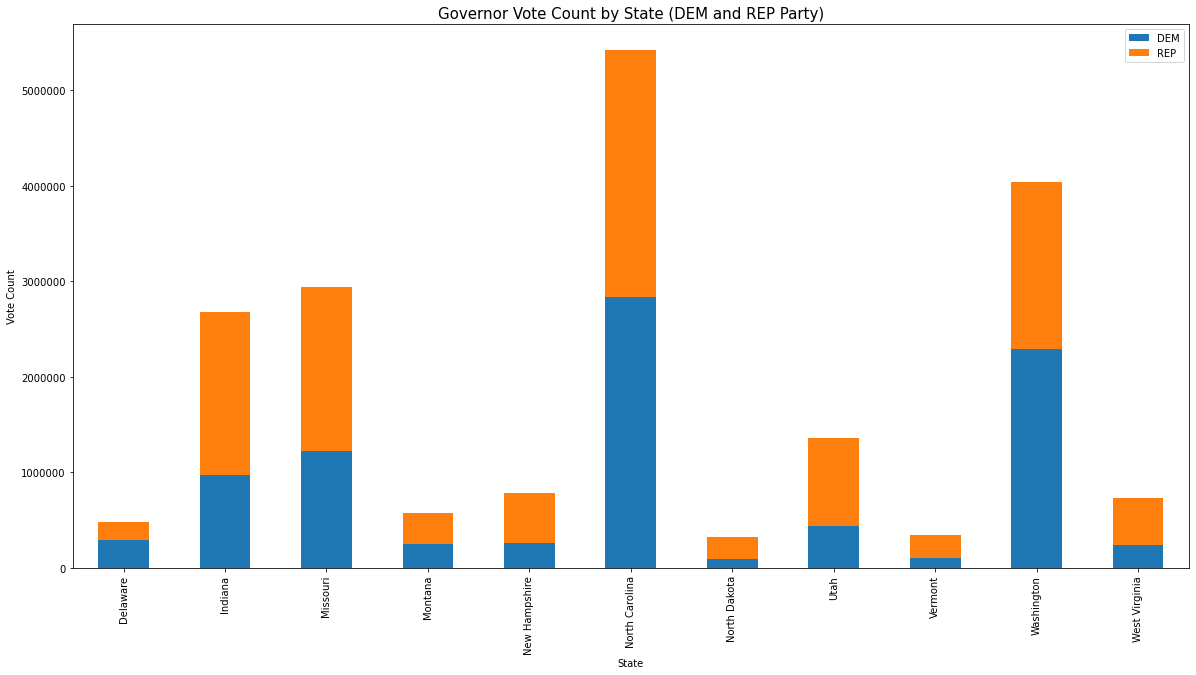

In [83]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
ax = votes_gov_by_state_and_party.loc[:,['votes_DEM', 'votes_REP']].plot.bar(stacked=True, figsize=(20,10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.title('Governor Vote Count by State (DEM and REP Party)', fontsize=15)
plt.xlabel('State')
plt.ylabel('Vote Count')
plt.legend(['DEM', 'REP'])
plt.show();

### 2) Governor - Vote Count by County (DEM & REP Party)

a) Top 5 counties with highest Democratic Governor votes

In [84]:
#Top 5 counties with highest DEM votes
votes_gov_top5_counties = votes_gov.reset_index()
votes_gov_top5_counties_DEM = votes_gov_top5_counties[votes_gov_top5_counties['won_DEM'] == True]
votes_gov_top5_counties_DEM = votes_gov_top5_counties_DEM.nlargest(5, 'votes_DEM')
votes_gov_top5_counties_DEM

state              county  votes_DEM  votes_oth  votes_REP  \
947      Washington         King County     887374       3653     307022   
594  North Carolina         Wake County     410386      10104     209183   
562  North Carolina  Mecklenburg County     382726      10584     171123   
195        Missouri    St. Louis County     317327      10413     207535   
961      Washington    Snohomish County     244876       1607     189797   

     won_DEM  won_REP  
947     True    False  
594     True    False  
562     True    False  
195     True    False  
961     True    False

b) Top 5 counties with highest Republican Governor votes

In [85]:
#Top 5 counties with highest REP votes
votes_gov_top5_counties_REP = votes_gov_top5_counties[votes_gov_top5_counties['won_REP'] == True]
votes_gov_top5_counties_REP = votes_gov_top5_counties_REP.nlargest(5, 'votes_REP')
votes_gov_top5_counties_REP

state              county  votes_DEM  votes_oth  votes_REP  won_DEM  \
673        Utah    Salt Lake County     238249      24540     266177    False   
680        Utah         Utah County      52524      20460     208514    False   
962  Washington      Spokane County     131734       1053     161138    False   
192    Missouri  St. Charles County      87888       4495     128230    False   
31      Indiana     Hamilton County      58714      17121     117749    False   

     won_REP  
673     True  
680     True  
962     True  
192     True  
31      True

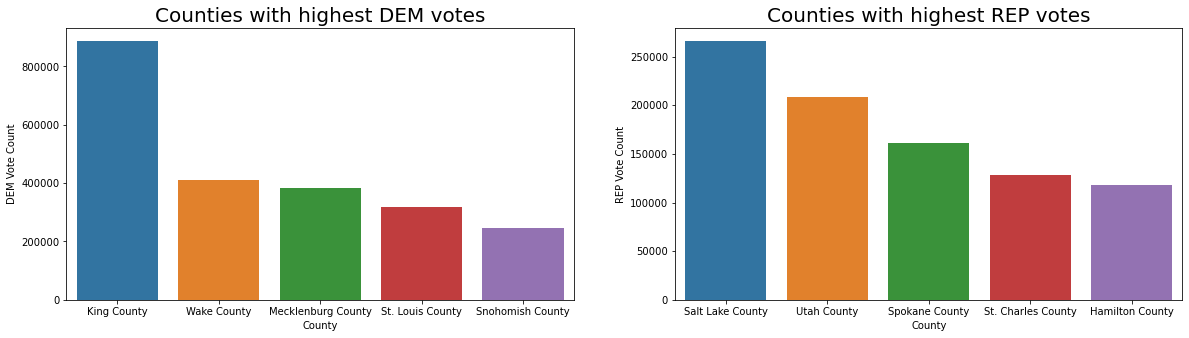

In [86]:
#Plot counties with highest no. of DEM votes in the US:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
ax1 = sns.barplot(votes_gov_top5_counties_DEM.county,votes_gov_top5_counties_DEM.votes_DEM)
ax1.set(xlabel='County', ylabel='DEM Vote Count')
plt.title('Counties with highest DEM votes',fontsize=20)

#Plot counties with highest no. of REP votes in the US:
plt.subplot(1,2,2)
ax2 = sns.barplot(votes_gov_top5_counties_REP.county,votes_gov_top5_counties_REP.votes_REP)
ax2.set(xlabel='County', ylabel='REP Vote Count')
plt.title('Counties with highest REP votes',fontsize=20)
plt.show();

### 3) Governor vs Presidential Election Results

In [87]:
#Create separate datasets for gov and pres election results
votes_pres_results = votes_pres

#Rename columns as per governor dataset:
votes_pres_results = votes_pres_results.rename(columns = {"votes_tru": "votes_REP", "votes_bid": "votes_DEM", "won_tru": "won_REP", "won_bid": "won_DEM"})

#Re-order columns as per governor dataset:
votes_pres_results = votes_pres_results[['state','county','votes_DEM','votes_oth','votes_REP','won_DEM','won_REP']]
votes_pres_results

state             county  votes_DEM  votes_oth  votes_REP  won_DEM  \
0     Alabama     Autauga County       7503        429      19838    False   
1     Alabama     Baldwin County      24578       1557      83544    False   
2     Alabama     Barbour County       4816         80       5622    False   
3     Alabama        Bibb County       1986         84       7525    False   
4     Alabama      Blount County       2640        237      24711    False   
...       ...                ...        ...        ...        ...      ...   
3155  Vermont     Orleans County       7147        437       6512     <NA>   
3156  Vermont     Rutland County      18230       1068      14672     <NA>   
3157  Vermont  Washington County      25191       1188       8928     <NA>   
3158  Vermont     Windham County      18767        828       6440     <NA>   
3159  Vermont     Windsor County      23376       1099       9971     <NA>   

      won_REP  
0        True  
1        True  
2        True  
3        True  
4        True  
...       ...  
3155     <NA>  
3156     <NA>  
3157     <NA>  
3158     <NA>  
3159     <NA>  

[3111 rows x 7 columns]

In [88]:
#Reset index for gov result set
votes_gov_results = votes_gov.reset_index()
votes_gov_results

state             county  votes_DEM  votes_oth  votes_REP  \
0          Delaware        Kent County      44352       1731      39332   
1          Delaware  New Castle County     191678       5816      82545   
2          Delaware      Sussex County      56873       1873      68435   
3           Indiana       Adams County       2143       2570       9441   
4           Indiana       Allen County      53895      16011      98406   
...             ...                ...        ...        ...        ...   
1020  West Virginia     Webster County        659        128       2552   
1021  West Virginia      Wetzel County       1727        267       4559   
1022  West Virginia        Wirt County        483        114       1947   
1023  West Virginia        Wood County       9933       2270      26232   
1024  West Virginia     Wyoming County       1240        139       6941   

      won_DEM  won_REP  
0        True    False  
1        True    False  
2       False     True  
3       False     True  
4       False     True  
...       ...      ...  
1020    False     True  
1021    False     True  
1022    False     True  
1023    False     True  
1024    False     True  

[1025 rows x 7 columns]

### a)  Vote count by County - Presidential vs Governor Elections

##### Presidential Election by County

In [89]:
#Merge latitude and longitude details with the dataset
votes_pres_results_latlong = lat_long_US_states_counties.merge(votes_pres_results, how='inner', left_on=["state_name", "county_name"], right_on=["state","county"])
votes_pres_results_latlong = votes_pres_results_latlong.drop(['state_name', 'county_name'], axis=1)
votes_pres_results_latlong

state_id      lat       lng         state                county  \
0          PA  40.0077  -75.1339  Pennsylvania   Philadelphia County   
1          CA  37.7562 -122.4430    California  San Francisco County   
2          CO  39.7621 -104.8759      Colorado         Denver County   
3          NY  40.6501  -73.9496      New York          Kings County   
4          NY  40.7498  -73.7976      New York         Queens County   
...       ...      ...       ...           ...                   ...   
2992       ID  44.1188 -111.3200         Idaho        Fremont County   
2993       OK  36.1334  -96.2091      Oklahoma          Tulsa County   
2994       MN  47.3198  -95.6952     Minnesota       Mahnomen County   
2995       OK  35.9113  -96.5772      Oklahoma          Creek County   
2996       NE  42.8307  -98.3296      Nebraska           Boyd County   

      votes_DEM  votes_oth  votes_REP  won_DEM  won_REP  
0        603790       4847     132740     True    False  
1        378156       8885      56417     True    False  
2        313293       8916      71618     True    False  
3        703310       7608     202772     True    False  
4        569038       6559     212665     True    False  
...         ...        ...        ...      ...      ...  
2992        998        173       5548    False     True  
2993     108996       7108     150574    False     True  
2994       1112         50       1142    False     True  
2995       6577        634      23294    False     True  
2996        135         10       1010    False     True  

[2997 rows x 10 columns]

In [90]:
# merge usa_state data and geo_usa shapefile
geo_merged_counties = geo_usa_county_new.merge(votes_pres_results_latlong, how ='inner', left_on=['NAME','NAME_s'], right_on=['county','state'])
geo_merged_counties = geo_merged_counties.drop(columns=['NAME_s'])
geo_merged_counties.head()

STATEFP COUNTYFP           NAME LSAD  \
0      37      017  Bladen County   06   
1      37      167  Stanly County   06   
2      37      105     Lee County   06   
3      37      007   Anson County   06   
4      37      185  Warren County   06   

                                            geometry state_id      lat  \
0  POLYGON ((-78.90200 34.83527, -78.79960 34.850...       NC  34.7339   
1  POLYGON ((-80.49737 35.20210, -80.29542 35.502...       NC  35.3763   
2  POLYGON ((-79.35007 35.51800, -79.24466 35.569...       NC  35.4579   
3  POLYGON ((-80.27683 35.19572, -80.17282 35.147...       NC  34.8148   
4  POLYGON ((-78.32372 36.54242, -78.13291 36.543...       NC  36.4396   

       lng           state         county  votes_DEM  votes_oth  votes_REP  \
0 -78.7910  North Carolina  Bladen County       7326        123       9676   
1 -80.3113  North Carolina  Stanly County       8129        352      25458   
2 -79.0547  North Carolina     Lee County      12143        396      16469   
3 -79.9766  North Carolina   Anson County       5789         84       5321   
4 -78.0839  North Carolina  Warren County       6400        141       3752   

   won_DEM  won_REP  
0    False     True  
1    False     True  
2    False     True  
3     True    False  
4     True    False

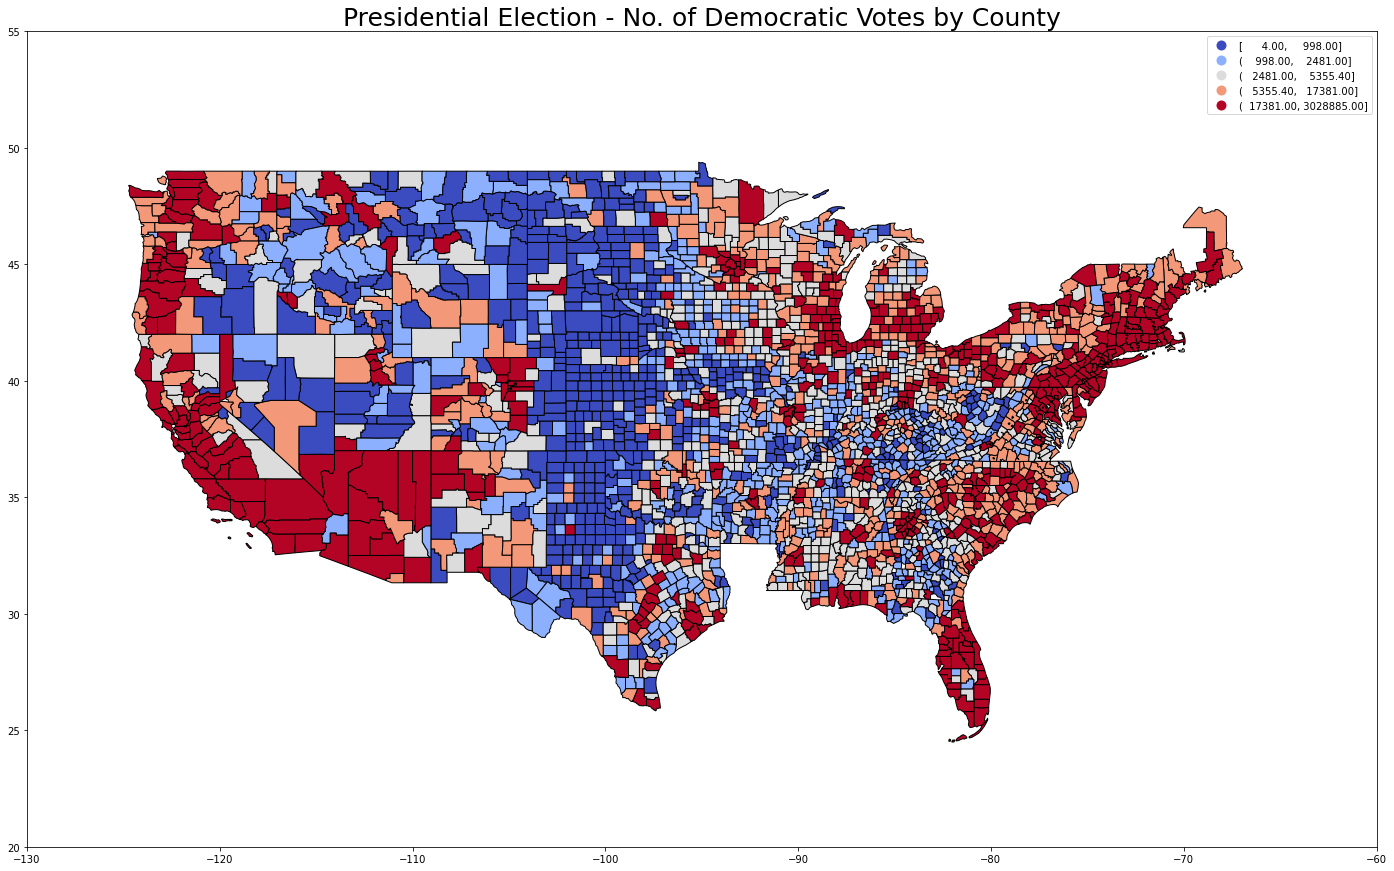

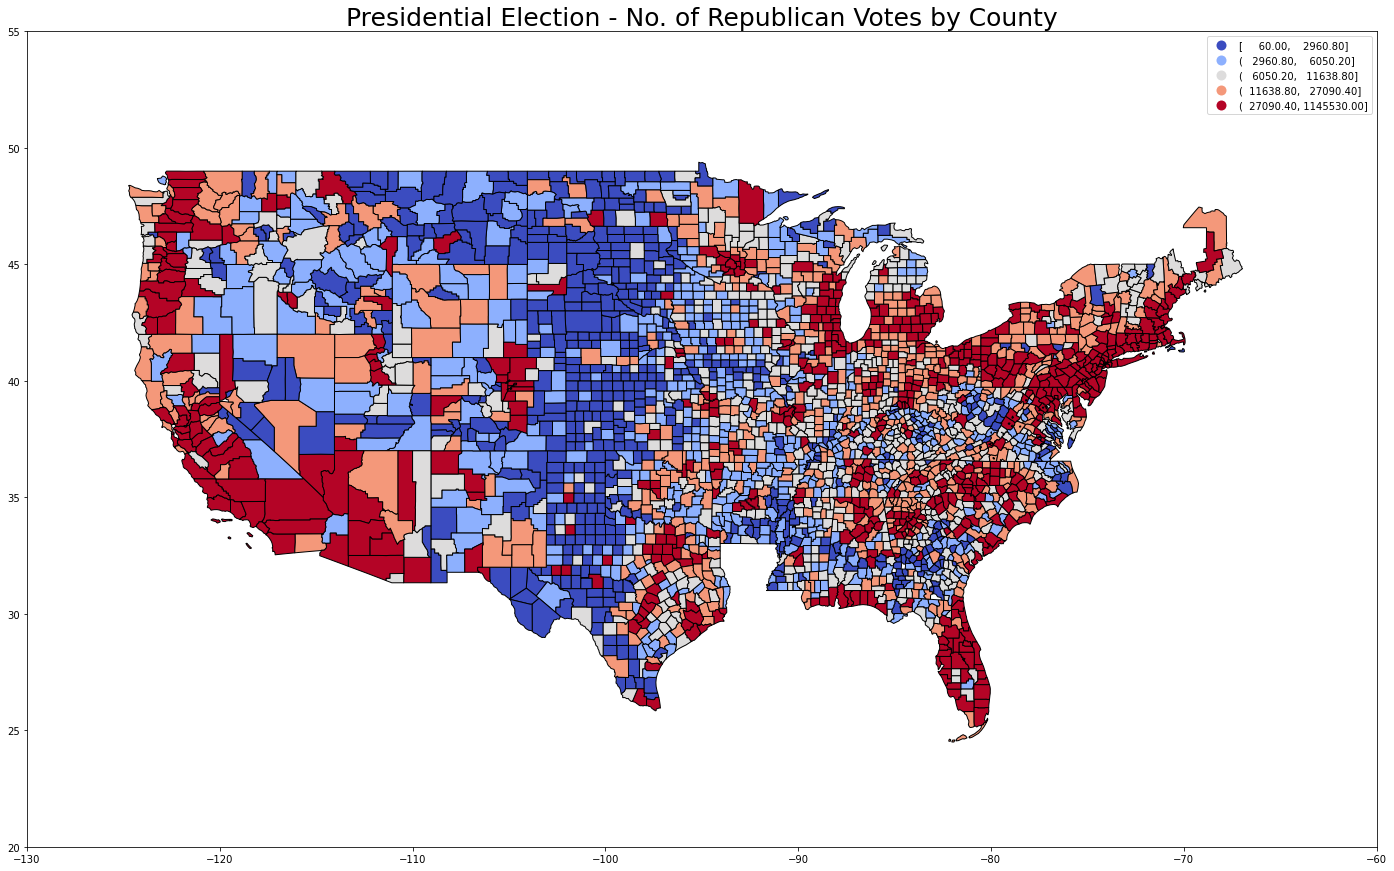

In [91]:
#Plot No. of DEM votes by county for Presidential Election:
geo_merged_counties.plot(column='votes_DEM', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm',edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Presidential Election - No. of Democratic Votes by County',fontsize=25)

#Plot No. of REP votes by county for Presidential Election:
geo_merged_counties.plot(column='votes_REP', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm',edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Presidential Election - No. of Republican Votes by County',fontsize=25)
plt.show()

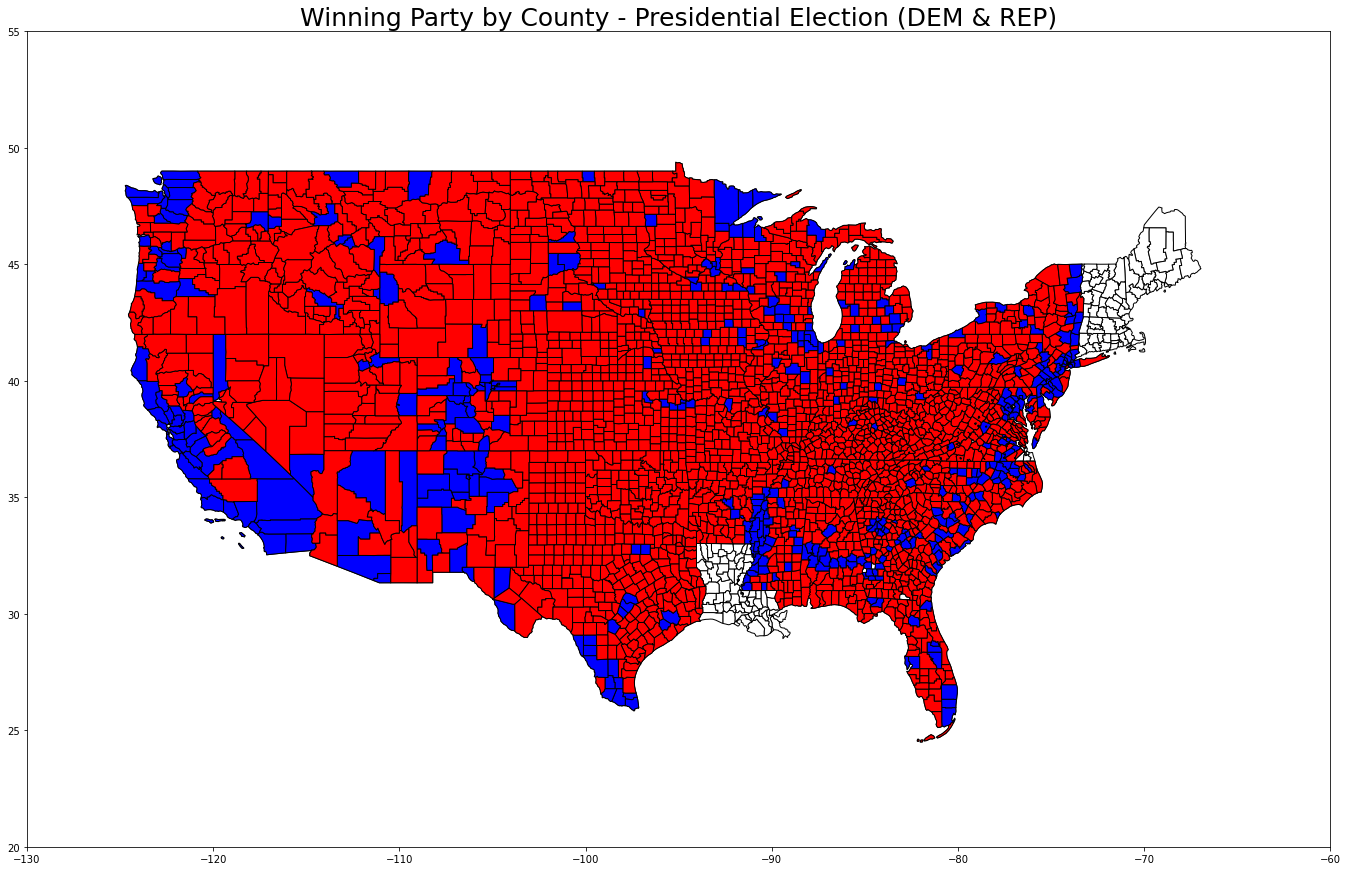

In [92]:
#Plot Counties with "winning party" votes - Presidential Election - BOTH DEM AND REP :
fig, ax = plt.subplots(figsize = (25,15)) 
geo_usa_county.plot(ax=ax, facecolor='white', edgecolor='black')
geo_merged_counties[geo_merged_counties.won_DEM == True].plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='blue', edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Winning Party by County - Presidential Election (DEM & REP)',fontsize=25)
geo_merged_counties[geo_merged_counties.won_REP == True].plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='red', edgecolor='black')
#plt.legend(labels=['DEM', 'REP'])
plt.show();

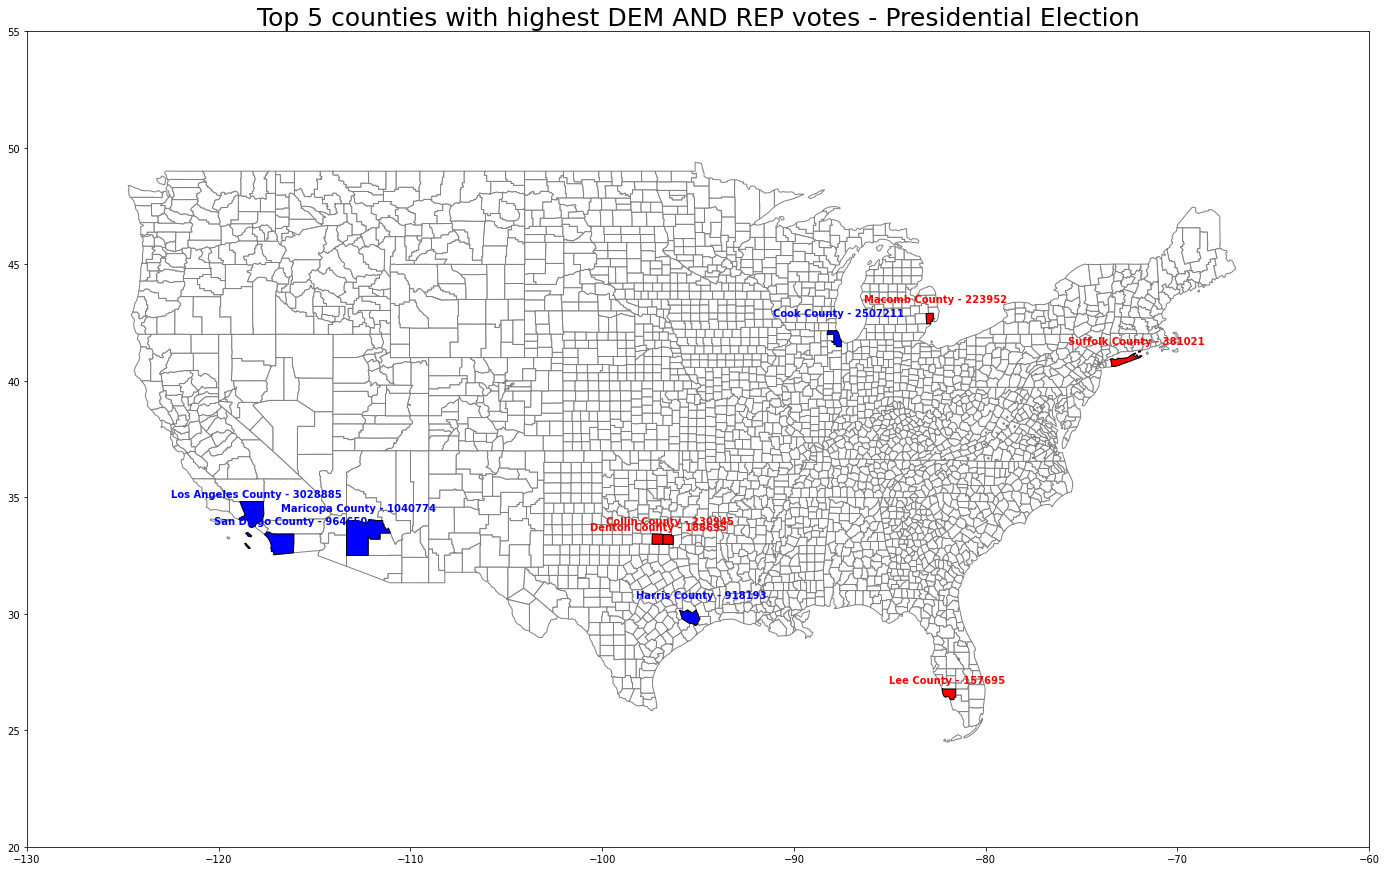

In [93]:
geo_highest_DEM = geo_merged_counties[(geo_merged_counties['won_DEM'] == True)].nlargest(5, 'votes_DEM').reset_index()
geo_highest_REP = geo_merged_counties[(geo_merged_counties['won_REP'] == True)].nlargest(5, 'votes_REP').reset_index()

#Plot tp 5 counties with highest DEM AND REP votes:
fig, ax = plt.subplots(figsize = (25,15)) 
geo_usa_county.plot(ax=ax, facecolor='white', edgecolor='grey')
geo_highest_DEM.plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='blue', edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Top 5 counties with highest DEM AND REP votes - Presidential Election',fontsize=25)
geo_highest_REP.plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='red', edgecolor='black')
#plt.legend(labels=['DEM', 'REP'])

#Label the counties and list the no. of votes per party:
for i in range(len(geo_highest_DEM.index)):
    plt.text(geo_highest_DEM.lng[i],geo_highest_DEM.lat[i],"\n  {} - {}\n\n".format(geo_highest_DEM.county[i],geo_highest_DEM.votes_DEM[i]),fontsize=10, fontweight ='bold', ha='center', color='blue')

for i in range(len(geo_highest_REP.index)):
    plt.text(geo_highest_REP.lng[i],geo_highest_REP.lat[i],"\n  {} - {}\n".format(geo_highest_REP.county[i],geo_highest_REP.votes_DEM[i]),fontsize=10, fontweight ='bold', ha='center', color='red')
 
plt.show();  

In [94]:
geo_highest_DEM

index STATEFP COUNTYFP                NAME LSAD  \
0   2820      06      037  Los Angeles County   06   
1   2169      17      031         Cook County   06   
2   2801      04      013     Maricopa County   06   
3   2834      06      073    San Diego County   06   
4    460      48      201       Harris County   06   

                                            geometry state_id      lat  \
0  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...       CA  34.0019   
1  POLYGON ((-88.26364 42.06687, -88.23826 42.092...       IL  41.7959   
2  POLYGON ((-113.33392 33.37742, -113.33333 33.5...       AZ  33.4187   
3  POLYGON ((-117.59619 33.38696, -117.57848 33.4...       CA  32.8711   
4  POLYGON ((-95.96061 30.16363, -95.80333 30.090...       TX  29.6765   

        lng       state              county  votes_DEM  votes_oth  votes_REP  \
0 -118.2106  California  Los Angeles County    3028885      89028    1145530   
1  -87.8410    Illinois         Cook County    2507211      55542     935304   
2 -112.8666     Arizona     Maricopa County    1040774      33036     995665   
3 -116.4247  California    San Diego County     964650      36978     600094   
4  -95.0027       Texas       Harris County     918193      21995     700630   

   won_DEM  won_REP  
0     True    False  
1     True    False  
2     True    False  
3     True    False  
4     True    False

In [95]:
geo_highest_REP

index STATEFP COUNTYFP            NAME LSAD  \
0   1792      36      103  Suffolk County   06   
1   1512      26      099   Macomb County   06   
2    393      48      085   Collin County   06   
3   1721      12      071      Lee County   06   
4    461      48      121   Denton County   06   

                                            geometry state_id      lat  \
0  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...       NY  41.0931   
1  POLYGON ((-83.10289 42.88865, -82.98365 42.893...       MI  42.8956   
2  POLYGON ((-96.84185 33.08646, -96.83779 33.262...       TX  33.3300   
3  POLYGON ((-82.28054 26.78931, -82.20556 26.770...       FL  26.5205   
4  POLYGON ((-97.39267 33.18351, -97.38309 33.430...       TX  33.0985   

       lng     state          county  votes_DEM  votes_oth  votes_REP  \
0 -72.3417  New York  Suffolk County     381021       9267     381253   
1 -82.7689  Michigan   Macomb County     223952       6441     263863   
2 -96.6676     Texas   Collin County     230945       8953     252318   
3 -82.1910   Florida      Lee County     157695       2957     233247   
4 -97.2304     Texas   Denton County     188695       6789     222480   

   won_DEM  won_REP  
0    False     True  
1    False     True  
2    False     True  
3    False     True  
4    False     True

##### Governor Election by County

In [96]:
#Extract lat and long details - DEM 
votes_gov_results_latlong_DEM = lat_long_US_states_counties.merge(votes_gov_top5_counties_DEM, how='inner', left_on=["state_name", "county_name"], right_on=["state","county"])
votes_gov_results_latlong_DEM = votes_gov_results_latlong_DEM.drop(['state_name', 'county_name'], axis=1)
votes_gov_results_latlong_DEM

state_id      lat       lng           state              county  votes_DEM  \
0       NC  35.0864  -80.8915  North Carolina  Mecklenburg County     382726   
1       NC  35.8318  -78.3162  North Carolina         Wake County     410386   
2       WA  47.7661 -121.4803      Washington         King County     887374   
3       WA  48.2018 -122.2459      Washington    Snohomish County     244876   
4       MO  38.7450  -90.4538        Missouri    St. Louis County     317327   

   votes_oth  votes_REP  won_DEM  won_REP  
0      10584     171123     True    False  
1      10104     209183     True    False  
2       3653     307022     True    False  
3       1607     189797     True    False  
4      10413     207535     True    False

In [97]:
# merge counties dataset and geo_usa_county shapefile - DEM
geo_merged_gov_counties_DEM = geo_usa_county_new.merge(votes_gov_results_latlong_DEM, how ='inner', left_on=['NAME','NAME_s'], right_on=['county','state'])
geo_merged_gov_counties_DEM = geo_merged_gov_counties_DEM.drop(columns=['NAME_s'])
#geo_merged_gov_counties_DEM.head()

In [98]:
#Extract lat and long details - REP 
votes_gov_results_latlong_REP = lat_long_US_states_counties.merge(votes_gov_top5_counties_REP, how='inner', left_on=["state_name", "county_name"], right_on=["state","county"])
votes_gov_results_latlong_REP = votes_gov_results_latlong_REP.drop(['state_name', 'county_name'], axis=1)
votes_gov_results_latlong_REP.head()

state_id      lat       lng       state              county  votes_DEM  \
0       IN  40.2139  -86.0271     Indiana     Hamilton County      58714   
1       UT  40.5818 -111.6229        Utah    Salt Lake County     238249   
2       UT  40.2462 -112.0843        Utah         Utah County      52524   
3       WA  47.3381 -117.2312  Washington      Spokane County     131734   
4       MO  38.7042  -90.6855    Missouri  St. Charles County      87888   

   votes_oth  votes_REP  won_DEM  won_REP  
0      17121     117749    False     True  
1      24540     266177    False     True  
2      20460     208514    False     True  
3       1053     161138    False     True  
4       4495     128230    False     True

In [99]:
# merge counties dataset and geo_usa_county shapefile - REP
geo_merged_gov_counties_REP = geo_usa_county_new.merge(votes_gov_results_latlong_REP, how ='inner', left_on=['NAME','NAME_s'], right_on=['county','state'])
geo_merged_gov_counties_REP = geo_merged_gov_counties_REP.drop(columns=['NAME_s'])
#geo_merged_gov_counties_REP.head()

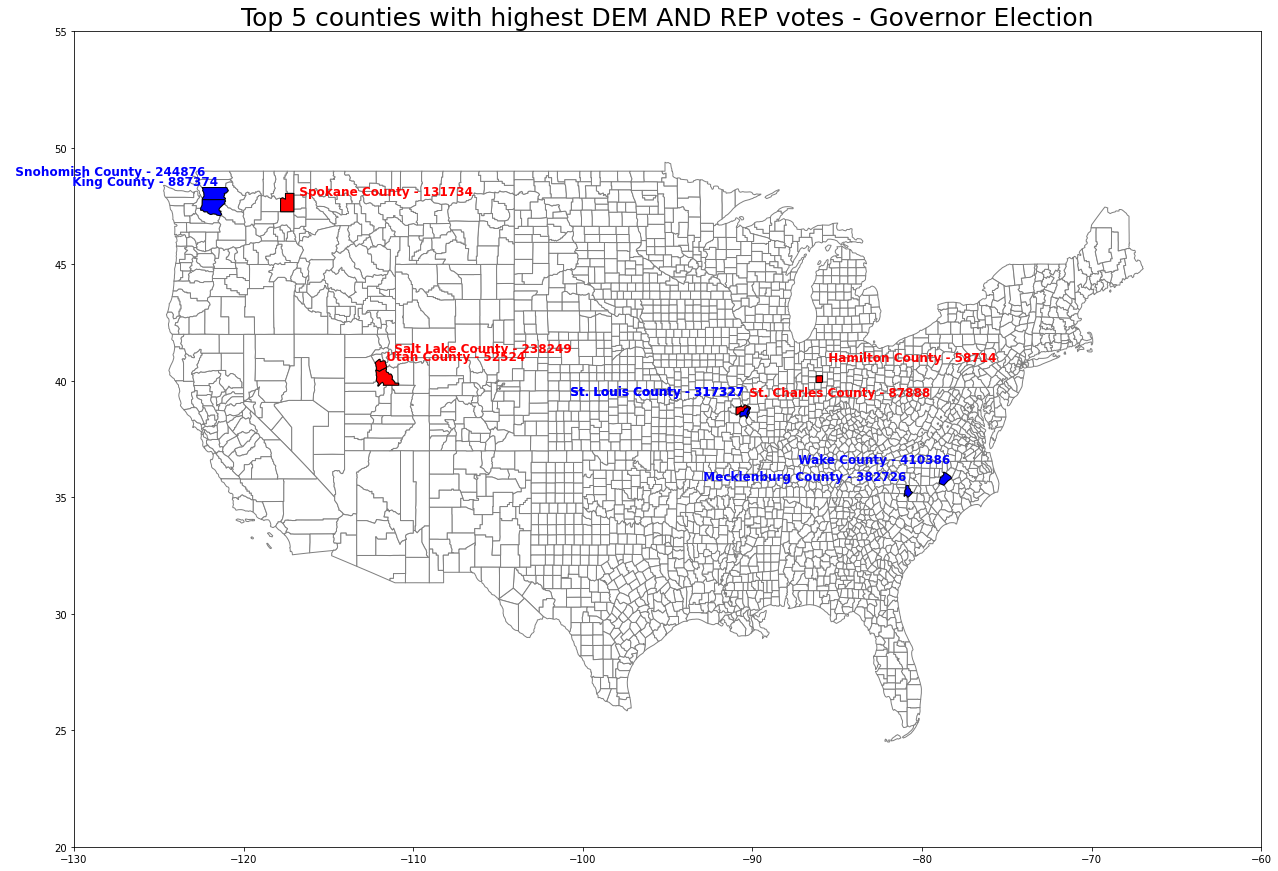

In [100]:
#Plot top 5 counties with highest DEM AND REP votes:
fig, ax = plt.subplots(figsize = (25,15)) 
geo_usa_county.plot(ax=ax, facecolor='white', edgecolor='grey')
geo_merged_gov_counties_DEM.plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='blue', edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Top 5 counties with highest DEM AND REP votes - Governor Election',fontsize=25)
geo_merged_gov_counties_REP.plot(ax=ax,column='NAME',scheme="quantiles",figsize=(25, 15),legend=True,color='red', edgecolor='black')
#plt.legend(labels=['DEM', 'REP'])

#Label the counties and list the no. of votes per party:
for i in range(len(geo_merged_gov_counties_DEM.index)):
    plt.text(geo_merged_gov_counties_DEM.lng[i],geo_merged_gov_counties_DEM.lat[i],"\n  {} - {}\n".format(geo_merged_gov_counties_DEM.county[i],geo_merged_gov_counties_DEM.votes_DEM[i]),fontsize=12, fontweight ='bold', ha='right', color='blue')

for i in range(len(geo_merged_gov_counties_REP.index)):
    plt.text(geo_merged_gov_counties_REP.lng[i],geo_merged_gov_counties_REP.lat[i],"\n  {} - {}\n".format(geo_merged_gov_counties_REP.county[i],geo_merged_gov_counties_REP.votes_DEM[i]),fontsize=12, fontweight ='bold', ha='left', color='red')
   

plt.show();

In [118]:
geo_merged_gov_counties_REP

STATEFP COUNTYFP                NAME LSAD  \
0      18      057     Hamilton County   06   
1      29      183  St. Charles County   06   
2      53      063      Spokane County   06   
3      49      049         Utah County   06   
4      49      035    Salt Lake County   06   

                                            geometry state_id      lat  \
0  POLYGON ((-86.24274 40.21583, -85.86190 40.218...       IN  40.2139   
1  POLYGON ((-90.95854 38.87086, -90.81783 38.875...       MO  38.7042   
2  POLYGON ((-117.82095 47.82578, -117.69777 47.8...       WA  47.3381   
3  POLYGON ((-112.21225 40.45911, -112.17286 40.4...       UT  40.2462   
4  POLYGON ((-112.26022 40.76909, -112.00657 40.9...       UT  40.5818   

        lng       state              county  votes_DEM  votes_oth  votes_REP  \
0  -86.0271     Indiana     Hamilton County      58714      17121     117749   
1  -90.6855    Missouri  St. Charles County      87888       4495     128230   
2 -117.2312  Washington      Spokane County     131734       1053     161138   
3 -112.0843        Utah         Utah County      52524      20460     208514   
4 -111.6229        Utah    Salt Lake County     238249      24540     266177   

   won_DEM  won_REP  
0    False     True  
1    False     True  
2    False     True  
3    False     True  
4    False     True

In [119]:
geo_merged_gov_counties_DEM

STATEFP COUNTYFP                NAME LSAD  \
0      37      119  Mecklenburg County   06   
1      37      183         Wake County   06   
2      29      189    St. Louis County   06   
3      29      510    St. Louis County   25   
4      53      061    Snohomish County   06   
5      53      033         King County   06   

                                            geometry state_id      lat  \
0  POLYGON ((-81.05803 35.07319, -81.03676 35.122...       NC  35.0864   
1  POLYGON ((-78.93627 35.77190, -78.90942 35.842...       NC  35.8318   
2  POLYGON ((-90.73233 38.63930, -90.66051 38.688...       MO  38.7450   
3  POLYGON ((-90.31821 38.60002, -90.25174 38.718...       MO  38.7450   
4  POLYGON ((-122.45860 48.29770, -122.20127 48.2...       WA  48.2018   
5  POLYGON ((-122.53699 47.40335, -122.44503 47.5...       WA  47.7661   

        lng           state              county  votes_DEM  votes_oth  \
0  -80.8915  North Carolina  Mecklenburg County     382726      10584   
1  -78.3162  North Carolina         Wake County     410386      10104   
2  -90.4538        Missouri    St. Louis County     317327      10413   
3  -90.4538        Missouri    St. Louis County     317327      10413   
4 -122.2459      Washington    Snohomish County     244876       1607   
5 -121.4803      Washington         King County     887374       3653   

   votes_REP  won_DEM  won_REP  
0     171123     True    False  
1     209183     True    False  
2     207535     True    False  
3     207535     True    False  
4     189797     True    False  
5     307022     True    False

### b)  Vote count by State - Presidential vs Governor Elections

##### Presidential Election by State

In [101]:
#Group presidential results by state:
votes_pres_results_by_state = votes_pres_results.groupby('state', as_index=False).sum()
votes_pres_results_by_state.head()

state  votes_DEM  votes_oth  votes_REP  won_DEM  won_REP
0     Alabama     849648      32488    1441168       13       54
1     Arizona    1672143      53497    1661686        5       10
2    Arkansas     423932      34490     760647        8       67
3  California   11109764     380181    6005961       35       23
4    Colorado    1804352      87994    1364607       24       40

In [102]:
#Calculate wins of DEM and REP party based on vote count:
votes_pres_results_by_state['won_DEM'] = votes_pres_results_by_state['won_DEM'].astype('bool')
votes_pres_results_by_state['won_REP'] = votes_pres_results_by_state['won_REP'].astype('bool')
for i in range(len(votes_pres_results_by_state)):
    if(votes_pres_results_by_state.votes_DEM[i] > votes_pres_results_by_state.votes_REP[i]):
        votes_pres_results_by_state.won_DEM[i] = True
        votes_pres_results_by_state.won_REP[i] = False
    else:
        votes_pres_results_by_state.won_REP[i] = True
        votes_pres_results_by_state.won_DEM[i] = False
votes_pres_results_by_state.head()

state  votes_DEM  votes_oth  votes_REP  won_DEM  won_REP
0     Alabama     849648      32488    1441168    False     True
1     Arizona    1672143      53497    1661686     True    False
2    Arkansas     423932      34490     760647    False     True
3  California   11109764     380181    6005961     True    False
4    Colorado    1804352      87994    1364607     True    False

In [103]:
# merge data with geo_usa_state shapefile
geo_merged_states = geo_usa_state.merge(votes_pres_results_by_state, how ='inner', left_on=['NAME'], right_on=['state'])
geo_merged_states.head()

STATEFP STUSPS          NAME LSAD  \
0      24     MD      Maryland   00   
1      19     IA          Iowa   00   
2      10     DE      Delaware   00   
3      39     OH          Ohio   00   
4      42     PA  Pennsylvania   00   

                                            geometry         state  votes_DEM  \
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...      Maryland    1985023   
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...          Iowa     759061   
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...      Delaware     296268   
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...          Ohio    2679165   
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...  Pennsylvania    3459923   

   votes_oth  votes_REP  won_DEM  won_REP  
0      75593     976414     True    False  
1      34138     897672    False     True  
2       7139     200603     True    False  
3      88203    3154834    False     True  
4      87069    3378263     True    False

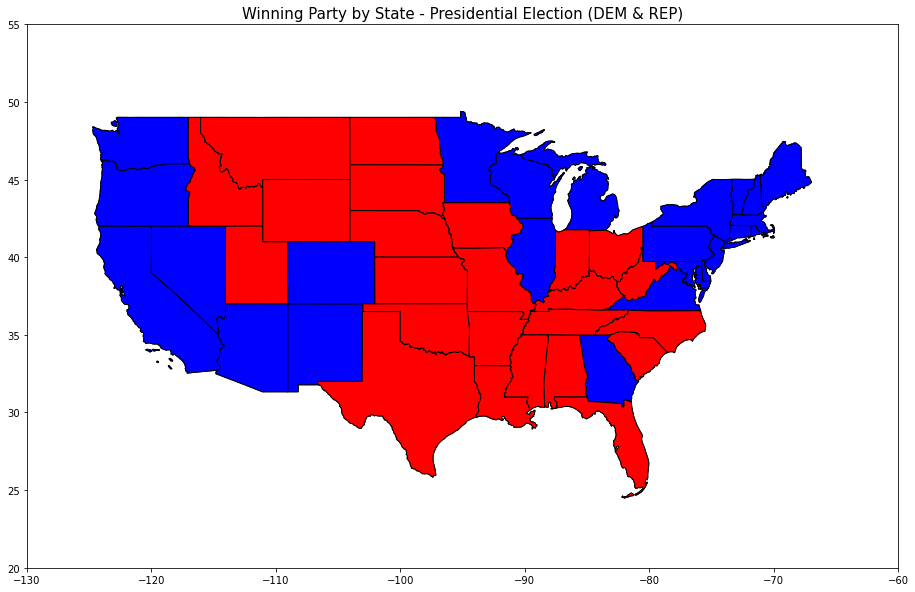

In [104]:
#Plot States with "winning party" votes - Presidential Election - BOTH DEM AND REP :
fig, ax = plt.subplots(figsize = (20,10)) 
geo_usa_state.plot(ax=ax, facecolor='white', edgecolor='black')
geo_merged_states[geo_merged_states.won_DEM == True].plot(ax=ax,column='NAME',scheme="quantiles",legend=True,color='blue', edgecolor='black')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Winning Party by State - Presidential Election (DEM & REP)',fontsize=15)
geo_merged_states[geo_merged_states.won_REP == True].plot(ax=ax,column='NAME',scheme="quantiles",legend=True,color='red', edgecolor='black')
#plt.legend(labels=['DEM', 'REP'])
plt.show();

##### Compare presential vs governor dataset - Vote count by State

In [105]:
#Merge presential and governor dataframes
pres_gov_merged_data_by_state_county = votes_pres_results.merge(votes_gov_results,
                     left_on=['state', 'county'],
                     right_on=['state', 'county'],
                     suffixes=('_pres', '_gov'))
pres_gov_merged_data_by_state_county

state             county  votes_DEM_pres  votes_oth_pres  \
0         Delaware        Kent County           44552            1464   
1         Delaware  New Castle County          195034            4235   
2         Delaware      Sussex County           56682            1440   
3          Indiana       Adams County            3236             287   
4          Indiana       Allen County           73189            3810   
..             ...                ...             ...             ...   
537  West Virginia     Webster County             610              33   
538  West Virginia      Wetzel County            1539             135   
539  West Virginia        Wirt County             466              53   
540  West Virginia        Wood County           10926             634   
541  West Virginia     Wyoming County            1157              82   

     votes_REP_pres  won_DEM_pres  won_REP_pres  votes_DEM_gov  votes_oth_gov  \
0             41009          True         False          44352           1731   
1             88364          True         False         191678           5816   
2             71230         False          True          56873           1873   
3             10686         False          True           2143           2570   
4             92083         False          True          53895          16011   
..              ...           ...           ...            ...            ...   
537            2759         False          True            659            128   
538            4993         False          True           1727            267   
539            2134         False          True            483            114   
540           27202         False          True           9933           2270   
541            7353         False          True           1240            139   

     votes_REP_gov  won_DEM_gov  won_REP_gov  
0            39332         True        False  
1            82545         True        False  
2            68435        False         True  
3             9441        False         True  
4            98406        False         True  
..             ...          ...          ...  
537           2552        False         True  
538           4559        False         True  
539           1947        False         True  
540          26232        False         True  
541           6941        False         True  

[542 rows x 12 columns]

In [106]:
votes_pres_gov_by_state_and_party = pres_gov_merged_data_by_state_county.groupby(['state'])[["votes_DEM_pres", "votes_DEM_gov", "votes_REP_pres", "votes_REP_gov"]].sum()
votes_pres_gov_by_state_and_party

votes_DEM_pres  votes_DEM_gov  votes_REP_pres  votes_REP_gov
state                                                                       
Delaware                296268         292903          200603         190312
Indiana                1242495         968092         1729852        1706724
Missouri               1253014        1225771         1718736        1720202
Montana                 244786         250860          343602         328548
North Carolina         2684292        2834790         2758773        2586604
North Dakota            114902          90789          235595         235479
Utah                    560282         442754          865140         918754
Washington             2369612        2294243         1584651        1749066
West Virginia           235984         237024          545382         497944

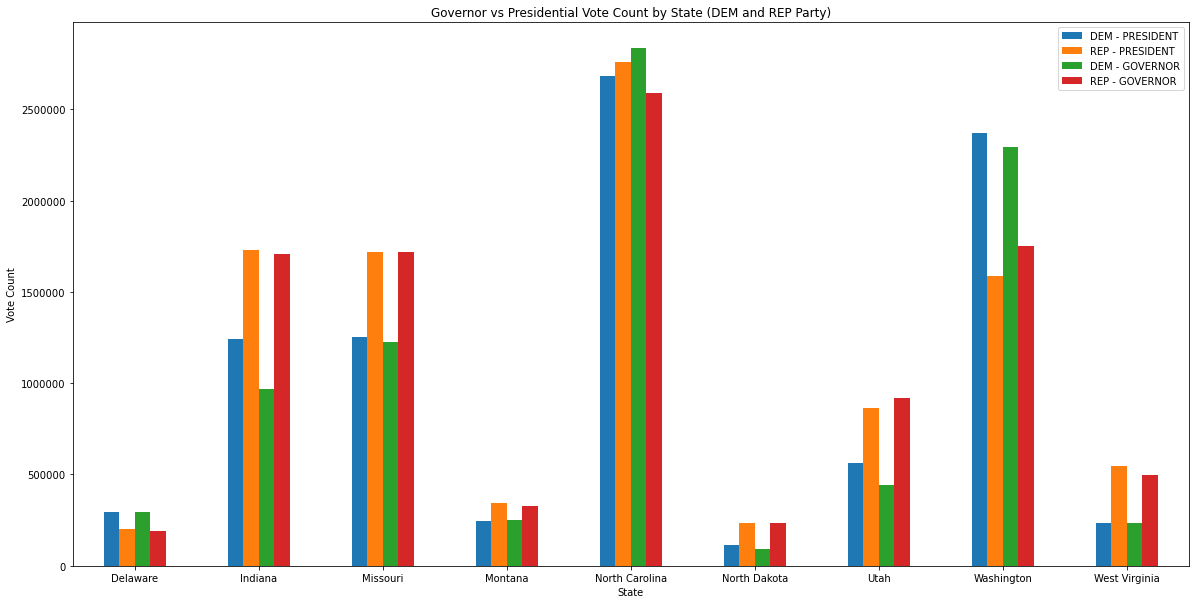

In [107]:
#Plot Presidential vs Governor vote count for Democratic vs Republican party by State:
votes_pres_gov_by_state_and_party[['votes_DEM_pres','votes_REP_pres', 'votes_DEM_gov', 'votes_REP_gov']].plot(kind='bar', figsize=(20,10), title="Governor vs Presidential Vote Count by State (DEM and REP Party)");
plt.ylabel('Vote Count')
plt.xlabel("State")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.legend(['DEM - PRESIDENT', 'REP - PRESIDENT', 'DEM - GOVERNOR', 'REP - GOVERNOR'])
plt.show();

### c) Race distribution - Presidential vs Governor Elections

In [108]:
#Check the combined race dataset:
cc19_ra.head(5)

state          county  TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  \
0  Alabama  Autauga County    55869     27092       28777    20878      21729   
1  Alabama  Baldwin County   223234    108247      114987    94810     100388   
2  Alabama  Barbour County    24686     13064       11622     6389       5745   
3  Alabama     Bibb County    22394     11929       10465     8766       8425   
4  Alabama   Blount County    57826     28472       29354    27258      28154   

   BAC_MALE  BAC_FEMALE  IAC_MALE  ...  mid_age  senior  child_m  yg_adlt_m  \
0      5514        6270       274  ...    15152   12294     6589       7725   
1     10346       11008      1818  ...    58282   62978    24031      27155   
2      6432        5685       182  ...     6204    6401     2551       4246   
3      3010        1897       106  ...     6079    5123     2340       3935   
4       658         618       400  ...    15164   14474     6586       7615   

   mid_age_m  senior_m  child_f  yg_adlt_f  mid_age_f  senior_f  
0       7301      5476     6199       7909       7851      6818  
1      27930     29130    23003      27784      30352     33848  
2       3412      2854     2482       2800       2792      3547  
3       3307      2347     2140       2776       2772      2776  
4       7575      6695     6500       7485       7589      7779  

[5 rows x 27 columns]

####  <u>Governor  - DEM Party winning counties</u>

In [109]:
#Merge top 5 counties with winning DEM party with race information  - GOVERNOR ELECTION
#votes_gov_top5_counties_DEM
votes_gov_top5_counties_DEM_with_race = votes_gov_top5_counties_DEM.merge(cc19_ra, on=['state','county'], how='left', indicator=True)
votes_gov_top5_counties_DEM_with_race = votes_gov_top5_counties_DEM_with_race[['state', 'county', 'votes_DEM', 'votes_REP', 
                                    'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 
                                    'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
                                    'AAC_FEMALE', 'H_MALE', 'H_FEMALE']]
votes_gov_top5_counties_DEM_with_race.set_index(['state', 'county'], inplace = True)
votes_gov_top5_counties_DEM_with_race

votes_DEM  votes_REP  TOT_POP  TOT_MALE  \
state          county                                                        
Washington     King County            887374     307022  2252782   1132272   
North Carolina Wake County            410386     209183  1111761    540765   
               Mecklenburg County     382726     171123  1110356    533670   
Missouri       St. Louis County       317327     207535   994205    472059   
Washington     Snohomish County       244876     189797   822083    412656   

                                   TOT_FEMALE  WA_MALE  WA_FEMALE  BAC_MALE  \
state          county                                                         
Washington     King County            1120510   755541     735602    101113   
North Carolina Wake County             570996   371942     382409    115290   
               Mecklenburg County      576686   313613     323011    174935   
Missouri       St. Louis County        522146   326179     348591    117194   
Washington     Snohomish County        409427   318547     314165     23382   

                                   BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  \
state          county                                                           
Washington     King County              95908     25755       26185    247870   
North Carolina Wake County             134326      8245        8554     47579   
               Mecklenburg County      209174      8313        9044     39273   
Missouri       St. Louis County        143890      3591        3893     26648   
Washington     Snohomish County         19428     12334       12393     56978   

                                   AAC_FEMALE  H_MALE  H_FEMALE  
state          county                                            
Washington     King County             260779  115691    106951  
North Carolina Wake County              48504   57898     57633  
               Mecklenburg County       38667   76958     75967  
Missouri       St. Louis County         27542   15100     14816  
Washington     Snohomish County         62307   45319     41848

####  <u>Governor  - REP Party winning counties</u>

In [110]:
#Merge top 5 counties with winning REP party with race information - GOVERNOR ELECTION
#votes_gov_top5_counties_REP
votes_gov_top5_counties_REP_with_race = votes_gov_top5_counties_REP.merge(cc19_ra, on=['state','county'], how='left', indicator=True)
votes_gov_top5_counties_REP_with_race = votes_gov_top5_counties_REP_with_race[['state', 'county', 'votes_DEM', 'votes_REP', 
                                    'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 
                                    'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
                                    'AAC_FEMALE', 'H_MALE', 'H_FEMALE']]
votes_gov_top5_counties_REP_with_race.set_index(['state', 'county'], inplace = True)
votes_gov_top5_counties_REP_with_race

votes_DEM  votes_REP  TOT_POP  TOT_MALE  \
state      county                                                        
Utah       Salt Lake County       238249     266177  1160437    582594   
           Utah County             52524     208514   636235    321408   
Washington Spokane County         131734     161138   522798    259299   
Missouri   St. Charles County      87888     128230   402022    197493   
Indiana    Hamilton County         58714     117749   338011    165068   

                               TOT_FEMALE  WA_MALE  WA_FEMALE  BAC_MALE  \
state      county                                                         
Utah       Salt Lake County        577843   507167     503869     19469   
           Utah County             314827   297866     291925      4763   
Washington Spokane County          263499   230272     234726     10012   
Missouri   St. Charles County      204529   176999     183267     12596   
Indiana    Hamilton County         172943   142782     149823      9164   

                               BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  \
state      county                                                           
Utah       Salt Lake County         16242     12559       12564     32310   
           Utah County               4134      4757        4539      9572   
Washington Spokane County            8218      8658        8882      9599   
Missouri   St. Charles County       12881      1518        1486      6521   
Indiana    Hamilton County           9334       905         957     12375   

                               AAC_FEMALE  H_MALE  H_FEMALE  
state      county                                            
Utah       Salt Lake County         34427  111452    106791  
           Utah County              10350   39524     37931  
Washington Spokane County           10880   16381     15454  
Missouri   St. Charles County        7094    7091      6663  
Indiana    Hamilton County          12960    7035      7412

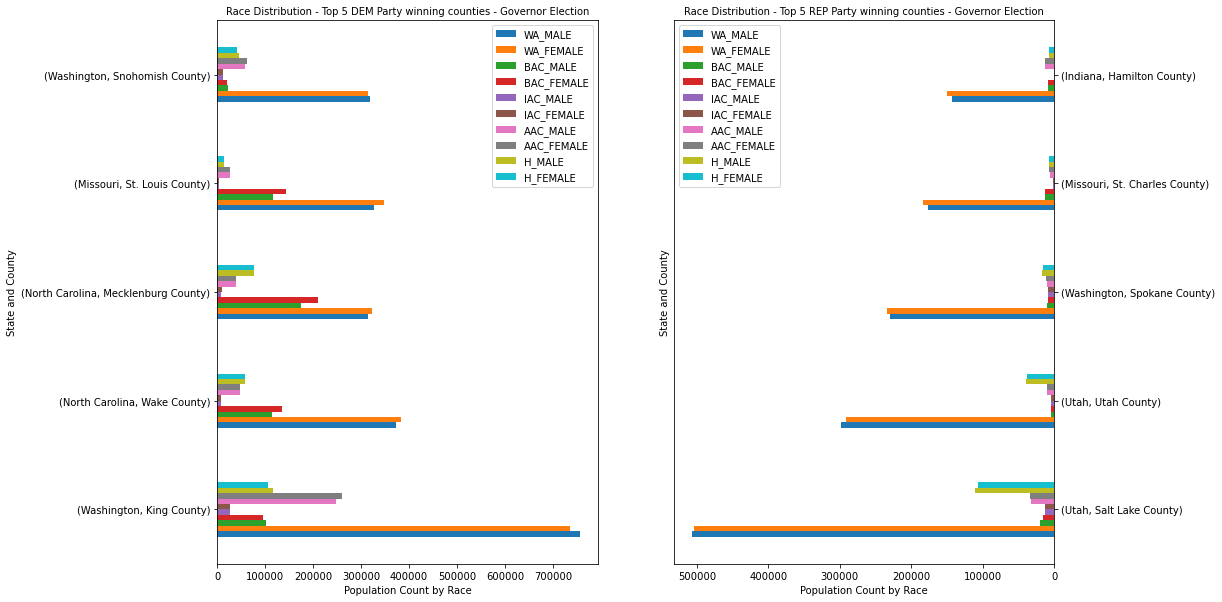

In [111]:
#a) Plot "Race Distribution - Top 5 DEM Party winning states/counties - Governor Election"
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
ax1 = votes_gov_top5_counties_DEM_with_race.loc[:,['WA_MALE', 'WA_FEMALE', 'BAC_MALE','BAC_FEMALE','IAC_MALE','IAC_FEMALE','AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']].plot(kind='barh', figsize=(15,10), ax=ax1)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_title('Race Distribution - Top 5 DEM Party winning counties - Governor Election', fontsize=10)
ax1.set(xlabel='Population Count by Race', ylabel='State and County')

#b)Plot "Race Distribution - Top 5 REP Party winning states/counties - Governor Election"
ax2 = votes_gov_top5_counties_REP_with_race.loc[:,['WA_MALE', 'WA_FEMALE', 'BAC_MALE','BAC_FEMALE','IAC_MALE','IAC_FEMALE','AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']].plot(kind='barh', figsize=(15,10), ax=ax2)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax2.set_title('Race Distribution - Top 5 REP Party winning counties - Governor Election', fontsize=10)
ax2.set(xlabel='Population Count by Race', ylabel='State and County')
plt.show();

####  <u>Presidential - DEM Party winning counties</u>

In [112]:
#Top 5 counties with highest DEM Presidential votes
votes_pres_top5_counties_DEM = votes_pres_results[votes_pres_results['won_DEM'] == True]
votes_pres_top5_counties_DEM = votes_pres_top5_counties_DEM.nlargest(5, 'votes_DEM')
votes_pres_top5_counties_DEM

state              county  votes_DEM  votes_oth  votes_REP  \
215   California  Los Angeles County    3028885      89028    1145530   
619     Illinois         Cook County    2507211      55542     935304   
114      Arizona     Maricopa County    1040774      33036     995665   
233   California    San Diego County     964650      36978     600094   
2588       Texas       Harris County     918193      21995     700630   

      won_DEM  won_REP  
215      True    False  
619      True    False  
114      True    False  
233      True    False  
2588     True    False

In [113]:
#Merge top 5 counties with winning DEM party with race information - PRESIDENTIAL ELECTION
votes_pres_top5_counties_DEM_with_race = votes_pres_top5_counties_DEM.merge(cc19_ra, on=['state','county'], how='left', indicator=True)
votes_pres_top5_counties_DEM_with_race = votes_pres_top5_counties_DEM_with_race[['state', 'county', 'votes_DEM', 'votes_REP', 
                                    'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 
                                    'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
                                    'AAC_FEMALE', 'H_MALE', 'H_FEMALE']]
votes_pres_top5_counties_DEM_with_race.set_index(['state', 'county'], inplace = True)
votes_pres_top5_counties_DEM_with_race

votes_DEM  votes_REP   TOT_POP  TOT_MALE  \
state      county                                                         
California Los Angeles County    3028885    1145530  10039107   4949041   
Illinois   Cook County           2507211     935304   5150233   2500872   
Arizona    Maricopa County       1040774     995665   4485414   2217230   
California San Diego County       964650     600094   3338330   1680017   
Texas      Harris County          918193     700630   4713325   2339443   

                               TOT_FEMALE  WA_MALE  WA_FEMALE  BAC_MALE  \
state      county                                                         
California Los Angeles County     5090066  3552806    3545503    476675   
Illinois   Cook County            2649361  1674529    1695554    582639   
Arizona    Maricopa County        2268184  1839169    1874727    172684   
California San Diego County       1658313  1274179    1243209    122126   
Texas      Harris County          2373882  1655138    1623551    462487   

                               BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  \
state      county                                                           
California Los Angeles County      524945    114903      114691    807269   
Illinois   Cook County             694089     33830       33902    216734   
Arizona    Maricopa County         172849     80979       85166    124998   
California San Diego County        108157     38530       37650    242558   
Texas      Harris County           521702     39520       37602    186715   

                               AAC_FEMALE   H_MALE  H_FEMALE  
state      county                                             
California Los Angeles County      908927  2434231   2447739  
Illinois   Cook County             234019   669766    649517  
Arizona    Maricopa County         136501   705642    703213  
California San Diego County        267152   566839    573194  
Texas      Harris County           195785  1050085   1010934

####  <u>Presidential - REP Party winning counties</u>

In [114]:
#Top 5 counties with highest REP Presidential votes
votes_pres_top5_counties_REP = votes_pres_results[votes_pres_results['won_REP'] == True]
votes_pres_top5_counties_REP = votes_pres_top5_counties_REP.nlargest(5, 'votes_REP')
votes_pres_top5_counties_REP

state          county  votes_DEM  votes_oth  votes_REP  won_DEM  \
1849  New York  Suffolk County     381021       9267     381253    False   
1260  Michigan   Macomb County     223952       6441     263863    False   
2530     Texas   Collin County     230945       8953     252318    False   
364    Florida      Lee County     157695       2957     233247    False   
2549     Texas   Denton County     188695       6789     222480    False   

      won_REP  
1849     True  
1260     True  
2530     True  
364      True  
2549     True

In [115]:
#Merge top 5 counties with winning REP party with race information - PRESIDENTIAL ELECTION
votes_pres_top5_counties_REP_with_race = votes_pres_top5_counties_REP.merge(cc19_ra, on=['state','county'], how='left', indicator=True)
votes_pres_top5_counties_REP_with_race = votes_pres_top5_counties_REP_with_race[['state', 'county', 'votes_DEM', 'votes_REP', 
                                    'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 
                                    'WA_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
                                    'AAC_FEMALE', 'H_MALE', 'H_FEMALE']]
votes_pres_top5_counties_REP_with_race.set_index(['state', 'county'], inplace = True)
votes_pres_top5_counties_REP_with_race

votes_DEM  votes_REP  TOT_POP  TOT_MALE  TOT_FEMALE  \
state    county                                                                
New York Suffolk County     381021     381253  1476601    726935      749666   
Michigan Macomb County      223952     263863   873972    425615      448357   
Texas    Collin County      230945     252318  1034730    509556      525174   
Florida  Lee County         157695     233247   770577    377301      393276   
Texas    Denton County      188695     222480   887207    436223      450984   

                         WA_MALE  WA_FEMALE  BAC_MALE  BAC_FEMALE  IAC_MALE  \
state    county                                                               
New York Suffolk County   613197     630442     71551       76469      8668   
Michigan Macomb County    345126     356426     55074       65380      4283   
Texas    Collin County    355041     361630     58006       64795      6907   
Florida  Lee County       328025     341107     37966       39670      3660   
Texas    Denton County    332455     338412     50964       57197      7019   

                         IAC_FEMALE  AAC_MALE  AAC_FEMALE  H_MALE  H_FEMALE  
state    county                                                              
New York Suffolk County        8414     35719       36929  153446    144983  
Michigan Macomb County         4839     21845       22682   12325     11759  
Texas    Collin County         6970     90550       92734   80677     79959  
Florida  Lee County            3299      7776        9496   87640     85857  
Texas    Denton County         7258     46483       48931   87138     86767

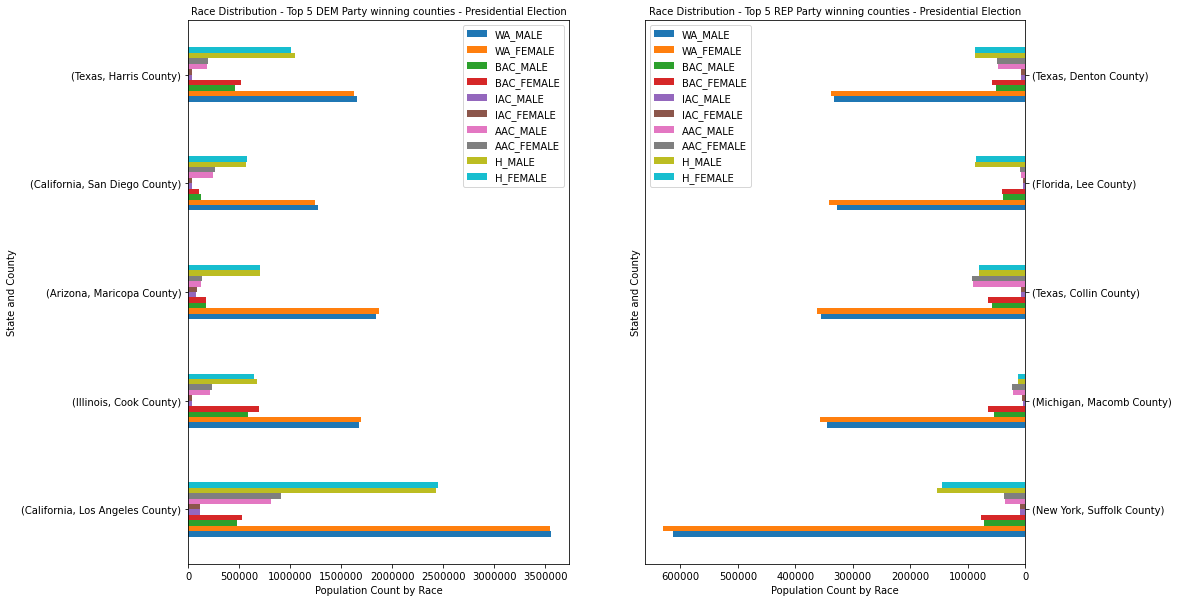

In [116]:
#c) Plot "Race Distribution - Top 5 DEM Party winning states/counties - Presidential Election"
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
ax1 = votes_pres_top5_counties_DEM_with_race.loc[:,['WA_MALE', 'WA_FEMALE', 'BAC_MALE','BAC_FEMALE','IAC_MALE','IAC_FEMALE','AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']].plot(kind='barh', figsize=(15,10), ax=ax1)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_title('Race Distribution - Top 5 DEM Party winning counties - Presidential Election', fontsize=10)
ax1.set(xlabel='Population Count by Race', ylabel='State and County')


#d) Plot "Race Distribution - Top 5 REP Party winning states/counties - Presidential Election"
ax2 = votes_pres_top5_counties_REP_with_race.loc[:,['WA_MALE', 'WA_FEMALE', 'BAC_MALE','BAC_FEMALE','IAC_MALE','IAC_FEMALE','AAC_MALE', 'AAC_FEMALE', 'H_MALE', 'H_FEMALE']].plot(kind='barh', figsize=(15,10), ax=ax2)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax2.set_title('Race Distribution - Top 5 REP Party winning counties - Presidential Election', fontsize=10)
ax2.set(xlabel='Population Count by Race', ylabel='State and County')
plt.show();

----